# Imports

In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from plotly import graph_objects as go
import plotly.io as pio

# naming a layout theme for future reference
pio.templates["letovo"] = go.layout.Template(
    layout_colorway=['#0D3174', '#FDC300', '#A40C30', '#00ADB9',
                     '#B2B2B2']
)

# setting Google color palette as default
pio.templates.default = "letovo"

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (16,10)
plt.rcParams['font.size'] = 22

sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['font.size'] = 22

YELLOW = '#FDC300'
BLUE = '#0D3174'
palette_dict = {1: YELLOW, 0: 'grey'}

# Task

Когорты обучения в курсах:
ID курса, название, даты, ID теста

1. Конверсия: заявки/одобрены/приступили
2. Результаты отборочного теста
3. Средний результат (% от макс баллов)
4. УП закончили больше 50%
5. УП закончили 100%
6. Абитуриенты (кол-во и %) от приступивших к курсу
7. Абитуриенты в рейтинге результатов : % от макс кол-ва баллов


# Load

In [2]:
df = pd.read_csv('students_course_resullts.csv', parse_dates=['course_start_at', 'accepted_at', 'created_at'])
df

,lo_id,grade,study_year_id,school_app,course_id,course_name,created_at,accepted_at,group_name,lessons_completed,course_start_at,course_lesson_cnt,student_score,max_score,test_result_final
0,523390,6,2,1,7,Биологический калейдоскоп,2022-09-08 13:52:34,2022-09-26 23:59:59,Биолог. калейдоскоп 26.09,9,2022-10-16 18:54:41,11,142,249,100.0
1,525181,6,2,1,7,Биологический калейдоскоп,2022-09-05 19:41:42,2022-09-26 23:59:59,Биолог. калейдоскоп 26.09,11,2022-09-28 13:37:00,11,192,249,5.0
2,530923,6,2,1,7,Биологический калейдоскоп,2022-09-06 18:39:22,2022-09-26 23:59:59,Биолог. калейдоскоп 26.09,7,2022-09-30 12:50:13,11,74,249,100.0
3,551221,5,1,1,7,Биологический калейдоскоп,2022-09-07 15:08:03,2022-09-26 23:59:59,Биолог. калейдоскоп 26.09,4,2022-09-28 11:56:59,11,69,249,5.0
4,575428,6,2,1,7,Биологический калейдоскоп,2022-09-07 19:47:42,2022-09-26 23:59:59,Биолог. калейдоскоп 26.09,7,2022-10-11 16:20:57,11,78,249,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2453,551162,6,2,0,63,Основы программирования на языке Python,2022-11-26 18:56:00,2022-11-28 14:10:31,Основы программирования 28.11,0,NaT,9,0,31,62.0
2454,526417,5,1,1,7,Биологический калейдоскоп,2023-01-05 17:23:37,2023-01-16 12:51:15,Биологический калейдоскоп 16.01,10,2023-01-16 18:35:07,11,128,249,70.0
2455,566936,7,3,1,63,Основы программирования на языке Python,2022-10-05 18:47:26,2023-01-16 12:55:13,Основы Python 24.10,0,NaT,9,0,31,81.0
2456,527409,7,3,1,77,Экономика фирмы,2023-01-08 16:35:49,2023-01-16 12:58:51,Экономика фирмы 16.01,3,2023-01-25 18:01:23,11,10,39,100.0


In [3]:
df.group_name = df.group_name.str[-5:]
df.group_name = pd.Categorical(df.group_name, ordered=True, categories=['26.09', '24.10', '28.11', '16.01'])
df.group_name

0       26.09
1       26.09
2       26.09
3       26.09
4       26.09
        ...  
2453    28.11
2454    16.01
2455    24.10
2456    16.01
2457    28.11
Name: group_name, Length: 2458, dtype: category
Categories (4, object): ['26.09' < '24.10' < '28.11' < '16.01']

In [4]:
app_per_user_count = df.groupby(['lo_id', 'course_name'])['lo_id'].count()
bad_users = app_per_user_count[app_per_user_count > 1].index.droplevel(1)
display(len(bad_users))
bad_df = df[df.lo_id.isin(bad_users)].sort_values(by=['lo_id', 'course_name'])
bad_df

102

,lo_id,grade,study_year_id,school_app,course_id,course_name,created_at,accepted_at,group_name,lessons_completed,course_start_at,course_lesson_cnt,student_score,max_score,test_result_final
430,402326,6,2,0,7,Биологический калейдоскоп,2022-10-01 21:48:23,2023-01-16 12:51:15,24.10,0,NaT,11,0,249,80.0
675,402326,6,2,0,7,Биологический калейдоскоп,2022-10-01 21:48:23,2023-01-16 12:51:15,16.01,0,NaT,11,0,249,80.0
333,444536,8,4,1,63,Основы программирования на языке Python,2022-11-23 21:14:28,2023-01-16 12:55:13,28.11,0,NaT,9,0,31,84.0
1334,444536,8,4,1,63,Основы программирования на языке Python,2022-11-23 21:14:28,2023-01-16 12:55:13,16.01,0,NaT,9,0,31,84.0
210,451851,8,4,1,63,Основы программирования на языке Python,2022-11-19 11:42:09,2023-01-16 12:55:13,16.01,0,NaT,9,0,31,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014,633796,5,1,0,8,Из чего сделано все вокруг? Начинаем изучать х...,2022-11-15 21:20:54,2022-11-28 14:36:35,28.11,1,2022-11-28 21:09:36,9,4,53,95.0
1937,633796,5,1,0,12,Математика для начинающих,2022-11-15 21:12:57,2022-11-28 13:55:46,28.11,1,2022-11-28 16:27:22,12,14,212,100.0
856,633796,5,1,0,14,Математическая физика для начинающих,2022-11-15 21:23:54,2022-11-28 14:27:57,28.11,3,2022-11-28 16:21:26,12,68,295,100.0
2066,633796,5,1,0,4,Подготовка к олимпиаде «Русский медвежонок»,2022-11-27 23:40:16,2023-01-16 12:57:14,28.11,0,NaT,7,0,56,100.0


Видим какое-то кол-во учеников, которые попали сразу в несколько групп. Тут правильно учитывать лишь самый последний поток.

In [5]:
df['accepted_at'] = df.groupby(['lo_id', 'course_name'])['accepted_at'].transform('max')

df = df.drop_duplicates(subset=['lo_id', 'course_name', 'accepted_at'])
app_per_user_count = df.groupby(['lo_id', 'course_name'])['lo_id'].count()
bad_users = app_per_user_count[app_per_user_count > 1].index.droplevel(1)
display(len(bad_users))


0

In [6]:
df['course_started'] = 0
df.loc[df['lessons_completed'] >= 1, 'course_started'] = 1

df['course_50'] = 0
df.loc[df['lessons_completed'] * 2 >= df['course_lesson_cnt'], 'course_50'] = 1

df['course_100'] = 0
df.loc[df['lessons_completed'] == df['course_lesson_cnt'], 'course_100'] = 1

df['percent_score'] = df['student_score'] / df['max_score']
df


,lo_id,grade,study_year_id,school_app,course_id,course_name,created_at,accepted_at,group_name,lessons_completed,course_start_at,course_lesson_cnt,student_score,max_score,test_result_final,course_started,course_50,course_100,percent_score
0,523390,6,2,1,7,Биологический калейдоскоп,2022-09-08 13:52:34,2022-09-26 23:59:59,26.09,9,2022-10-16 18:54:41,11,142,249,100.0,1,1,0,0.570281
1,525181,6,2,1,7,Биологический калейдоскоп,2022-09-05 19:41:42,2022-09-26 23:59:59,26.09,11,2022-09-28 13:37:00,11,192,249,5.0,1,1,1,0.771084
2,530923,6,2,1,7,Биологический калейдоскоп,2022-09-06 18:39:22,2022-09-26 23:59:59,26.09,7,2022-09-30 12:50:13,11,74,249,100.0,1,1,0,0.297189
3,551221,5,1,1,7,Биологический калейдоскоп,2022-09-07 15:08:03,2022-09-26 23:59:59,26.09,4,2022-09-28 11:56:59,11,69,249,5.0,1,0,0,0.277108
4,575428,6,2,1,7,Биологический калейдоскоп,2022-09-07 19:47:42,2022-09-26 23:59:59,26.09,7,2022-10-11 16:20:57,11,78,249,100.0,1,1,0,0.313253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2452,609462,5,1,1,12,Математика для начинающих,2022-09-09 18:52:06,2022-11-28 13:55:47,28.11,1,2022-12-06 06:45:28,12,4,212,75.0,1,0,0,0.018868
2453,551162,6,2,0,63,Основы программирования на языке Python,2022-11-26 18:56:00,2022-11-28 14:10:31,28.11,0,NaT,9,0,31,62.0,0,0,0,0.000000
2454,526417,5,1,1,7,Биологический калейдоскоп,2023-01-05 17:23:37,2023-01-16 12:51:15,16.01,10,2023-01-16 18:35:07,11,128,249,70.0,1,1,0,0.514056
2456,527409,7,3,1,77,Экономика фирмы,2023-01-08 16:35:49,2023-01-16 12:58:51,16.01,3,2023-01-25 18:01:23,11,10,39,100.0,1,0,0,0.256410


In [7]:

df_start = df[df.course_started == 1].copy()
df_school = df_start[df_start.school_app == 1].copy()

# Courses and groups info

In [8]:
course_apps = pd.read_csv('students_course_apps_groups.csv')
course_apps['group_name'] = course_apps['group_name'].astype(str)
course_apps.loc[course_apps['group_name'] == '24.1', 'group_name'] = '24.10'
course_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4179 entries, 0 to 4178
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   lo_id        4179 non-null   int64 
 1   course_name  4179 non-null   object
 2   group_name   4179 non-null   object
dtypes: int64(1), object(2)
memory usage: 98.1+ KB


In [9]:
course_apps['group_name'].unique()

array(['26.09', '24.10', '28.11', '16.01'], dtype=object)

In [10]:
course_apps['group_name'] = pd.Categorical(course_apps['group_name'], ordered=True, categories=['26.09', '24.10', '28.11', '16.01'])
course_apps['group_name']

0       26.09
1       26.09
2       26.09
3       26.09
4       26.09
        ...  
4174    16.01
4175    16.01
4176    16.01
4177    16.01
4178    16.01
Name: group_name, Length: 4179, dtype: category
Categories (4, object): ['26.09' < '24.10' < '28.11' < '16.01']

In [11]:
course_apps['group_name'].unique()

['26.09', '24.10', '28.11', '16.01']
Categories (4, object): ['26.09' < '24.10' < '28.11' < '16.01']

In [12]:
course_apps_count = course_apps.groupby(['course_name', 'group_name']).agg({'lo_id':'count'})
course_apps_count.columns = ['Заявки']
course_apps_count

Заявки
course_name                                        group_name        
Академическое письмо (Academic Writing)            26.09          231
                                                   24.10           52
                                                   28.11           49
                                                   16.01           34
Античная философия                                 26.09            0
                                                   24.10           17
                                                   28.11           11
                                                   16.01            6
Биологический калейдоскоп                          26.09          287
                                                   24.10           88
                                                   28.11           58
                                                   16.01           42
Из чего сделано все вокруг? Начинаем изучать химию 26.09           65
                                                   24.10           80
                                                   28.11           43
                                                   16.01           32
Лингвистика для начинающих                         26.09          146
                                                   24.10           37
                                                   28.11           28
                                                   16.01            0
Математика для начинающих                          26.09          415
                                                   24.10          117
                                                   28.11           83
                                                   16.01            0
Математическая физика для начинающих               26.09           64
                                                   24.10           79
                                                   28.11           63
                                                   16.01           53
Основы программирования на языке Python            26.09          571
                                                   24.10          165
                                                   28.11           89
                                                   16.01           86
Первые шаги в робототехнику                        26.09          133
                                                   24.10           46
                                                   28.11           27
                                                   16.01           21
Подготовка к олимпиаде «Русский медвежонок»        26.09          356
                                                   24.10           99
                                                   28.11           60
                                                   16.01           50
Семейная экономика                                 26.09           52
                                                   24.10           52
                                                   28.11           37
                                                   16.01           27
Финансовая грамотность                             26.09            0
                                                   24.10           41
                                                   28.11           33
                                                   16.01            0
Экономика фирмы                                    26.09            0
                                                   24.10           24
                                                   28.11           14
                                                   16.01           16

In [13]:
course_info = df.groupby(['course_name', 'group_name']).agg({
     'test_result_final':'mean',
    'lo_id':'count', 
    'course_started':'sum', 
    'course_50':'sum', 'course_100':'sum'
    })
course_info.columns = ['Тест (%)', 'Одобренные заявки', 'Приступили', '50%', '100%']
course_info

Тест (%)  \
course_name                                        group_name              
Академическое письмо (Academic Writing)            26.09       75.042254   
                                                   24.10       74.431373   
                                                   28.11       77.020833   
                                                   16.01       81.129032   
Античная философия                                 26.09             NaN   
                                                   24.10             NaN   
                                                   28.11       72.727273   
                                                   16.01       66.500000   
Биологический калейдоскоп                          26.09       78.134328   
                                                   24.10       82.741935   
                                                   28.11       86.666667   
                                                   16.01       72.432432   
Из чего сделано все вокруг? Начинаем изучать химию 26.09             NaN   
                                                   24.10       79.955357   
                                                   28.11       86.578947   
                                                   16.01       75.833333   
Лингвистика для начинающих                         26.09       93.347826   
                                                   24.10             NaN   
                                                   28.11       89.360656   
                                                   16.01             NaN   
Математика для начинающих                          26.09       71.040000   
                                                   24.10             NaN   
                                                   28.11       80.527778   
                                                   16.01             NaN   
Математическая физика для начинающих               26.09             NaN   
                                                   24.10       73.047619   
                                                   28.11       74.272727   
                                                   16.01       77.475000   
Основы программирования на языке Python            26.09       75.988701   
                                                   24.10       70.933333   
                                                   28.11       77.301075   
                                                   16.01       78.883117   
Первые шаги в робототехнику                        26.09       67.731707   
                                                   24.10       70.906250   
                                                   28.11       68.548387   
                                                   16.01       79.437500   
Подготовка к олимпиаде «Русский медвежонок»        26.09       82.925373   
                                                   24.10       81.530303   
                                                   28.11       83.766667   
                                                   16.01       84.416667   
Семейная экономика                                 26.09             NaN   
                                                   24.10       72.773333   
                                                   28.11       77.371429   
                                                   16.01       79.909091   
Финансовая грамотность                             26.09             NaN   
                                                   24.10             NaN   
                                                   28.11       77.861111   
                                                   16.01             NaN   
Экономика фирмы                                    26.09             NaN   
                                                   24.10             NaN   
                                                   28.11       85.884615   
                                    

In [14]:
course_start_info = df_start.groupby(['course_name', 'group_name']).agg({
    'school_app':'sum', 'percent_score':'mean'
})
course_start_info.columns = ['Заявки в школу', 'Средний результат (%)']
course_start_info

Заявки в школу  \
course_name                                        group_name                   
Академическое письмо (Academic Writing)            26.09                   54   
                                                   24.10                    8   
                                                   28.11                    9   
                                                   16.01                   10   
Античная философия                                 26.09                    0   
                                                   24.10                    0   
                                                   28.11                    2   
                                                   16.01                    3   
Биологический калейдоскоп                          26.09                   44   
                                                   24.10                   12   
                                                   28.11                   11   
                                                   16.01                   10   
Из чего сделано все вокруг? Начинаем изучать химию 26.09                    0   
                                                   24.10                   20   
                                                   28.11                    8   
                                                   16.01                    4   
Лингвистика для начинающих                         26.09                   15   
                                                   24.10                    0   
                                                   28.11                   10   
                                                   16.01                    0   
Математика для начинающих                          26.09                   26   
                                                   24.10                    0   
                                                   28.11                   30   
                                                   16.01                    0   
Математическая физика для начинающих               26.09                    0   
                                                   24.10                   14   
                                                   28.11                   18   
                                                   16.01                   10   
Основы программирования на языке Python            26.09                   74   
                                                   24.10                   27   
                                                   28.11                   22   
                                                   16.01                   14   
Первые шаги в робототехнику                        26.09                   12   
                                                   24.10                   11   
                                                   28.11                    7   
                                                   16.01                    2   
Подготовка к олимпиаде «Русский медвежонок»        26.09                   52   
                                                   24.10                   12   
                                                   28.11                   13   
                                                   16.01                   10   
Семейная экономика                                 26.09                    0   
                                                   24.10                   20   
                                                   28.11                    6   
                                                   16.01                    6   
Финансовая грамотность                             26.09                    0   
                                                   24.10                    0   
                                                   28.11                   13   
                                                   16.01                    0   
Экономика фир

In [15]:
course_school_result = df_school.groupby(['course_name', 'group_name']).agg({'percent_score':'mean'})
course_school_result.columns = ['Результат абитуриентов (%)']
course_school_result

Результат абитуриентов (%)
course_name                                        group_name                            
Академическое письмо (Academic Writing)            26.09                         0.335671
                                                   24.10                         0.308252
                                                   28.11                         0.238403
                                                   16.01                         0.242718
Античная философия                                 26.09                              NaN
                                                   24.10                              NaN
                                                   28.11                         0.531818
                                                   16.01                         0.375758
Биологический калейдоскоп                          26.09                         0.296459
                                                   24.10                         0.205489
                                                   28.11                         0.235487
                                                   16.01                         0.239759
Из чего сделано все вокруг? Начинаем изучать химию 26.09                              NaN
                                                   24.10                         0.224528
                                                   28.11                         0.134434
                                                   16.01                         0.146226
Лингвистика для начинающих                         26.09                         0.207527
                                                   24.10                              NaN
                                                   28.11                         0.229032
                                                   16.01                              NaN
Математика для начинающих                          26.09                         0.447025
                                                   24.10                              NaN
                                                   28.11                         0.336006
                                                   16.01                              NaN
Математическая физика для начинающих               26.09                              NaN
                                                   24.10                         0.182082
                                                   28.11                         0.251224
                                                   16.01                         0.226102
Основы программирования на языке Python            26.09                         0.434612
                                                   24.10                         0.344086
                                                   28.11                         0.368035
                                                   16.01                         0.543779
Первые шаги в робототехнику                        26.09                         0.395299
                                                   24.10                         0.384615
                                                   28.11                         0.227106
                                                   16.01                         0.384615
Подготовка к олимпиаде «Русский медвежонок»        26.09                         0.466690
                                                   24.10                         0.394345
                                                   28.11                         0.251374
                                                   16.01                         0.325000
Семейная экономика                                 26.09                              NaN
                                                   24.10                         0.345582
                                                   28.11                         0.265730
             

In [16]:
course_apps_count.join(course_info, how='left')

Заявки  \
course_name                                        group_name           
Академическое письмо (Academic Writing)            26.09          231   
                                                   24.10           52   
                                                   28.11           49   
                                                   16.01           34   
Античная философия                                 26.09            0   
                                                   24.10           17   
                                                   28.11           11   
                                                   16.01            6   
Биологический калейдоскоп                          26.09          287   
                                                   24.10           88   
                                                   28.11           58   
                                                   16.01           42   
Из чего сделано все вокруг? Начинаем изучать химию 26.09           65   
                                                   24.10           80   
                                                   28.11           43   
                                                   16.01           32   
Лингвистика для начинающих                         26.09          146   
                                                   24.10           37   
                                                   28.11           28   
                                                   16.01            0   
Математика для начинающих                          26.09          415   
                                                   24.10          117   
                                                   28.11           83   
                                                   16.01            0   
Математическая физика для начинающих               26.09           64   
                                                   24.10           79   
                                                   28.11           63   
                                                   16.01           53   
Основы программирования на языке Python            26.09          571   
                                                   24.10          165   
                                                   28.11           89   
                                                   16.01           86   
Первые шаги в робототехнику                        26.09          133   
                                                   24.10           46   
                                                   28.11           27   
                                                   16.01           21   
Подготовка к олимпиаде «Русский медвежонок»        26.09          356   
                                                   24.10           99   
                                                   28.11           60   
                                                   16.01           50   
Семейная экономика                                 26.09           52   
                                                   24.10           52   
                                                   28.11           37   
                                                   16.01           27   
Финансовая грамотность                             26.09            0   
                                                   24.10           41   
                                                   28.11           33   
                                                   16.01            0   
Экономика фирмы                                    26.09            0   
                                                   24.10           24   
                                                   28.11           14   
                                                   16.01           16   

                                                                Тест (%)  \
course_name                                 

In [17]:
course_info_fin = course_apps_count.join(course_info, how='left').join(course_start_info, how='left').join(course_school_result, how='left')

#Посчитаем реальное кол-во висящих заявок на дату одобрения:
course_info_fin.insert(2, 'Заявки на дату одобрения', course_info_fin.groupby(level=0).apply(
    lambda x: ((x['Заявки'] - x['Одобренные заявки']).shift(1).cumsum() + x['Заявки']).fillna(x['Заявки'])
    ).droplevel(0)
)
course_info_fin.insert(4, 'Одобренные (%)', course_info_fin['Одобренные заявки'] / course_info_fin['Заявки на дату одобрения'])
course_info_fin.insert(6, 'Приступили (%)', course_info_fin['Приступили'] / course_info_fin['Одобренные заявки'])
course_info_fin.insert(10, 'Заявки в школу (% от приступивших)', course_info_fin['Заявки в школу'] / course_info_fin['Приступили'])

course_info_fin = course_info_fin[course_info_fin['Одобренные заявки'] != 0]
#course_info_fin.to_excel('courses_groups_summary.xlsx')
course_info_fin

Заявки  \
course_name                                        group_name           
Академическое письмо (Academic Writing)            26.09          231   
                                                   24.10           52   
                                                   28.11           49   
                                                   16.01           34   
Античная философия                                 28.11           11   
                                                   16.01            6   
Биологический калейдоскоп                          26.09          287   
                                                   24.10           88   
                                                   28.11           58   
                                                   16.01           42   
Из чего сделано все вокруг? Начинаем изучать химию 24.10           80   
                                                   28.11           43   
                                                   16.01           32   
Лингвистика для начинающих                         26.09          146   
                                                   28.11           28   
Математика для начинающих                          26.09          415   
                                                   28.11           83   
Математическая физика для начинающих               24.10           79   
                                                   28.11           63   
                                                   16.01           53   
Основы программирования на языке Python            26.09          571   
                                                   24.10          165   
                                                   28.11           89   
                                                   16.01           86   
Первые шаги в робототехнику                        26.09          133   
                                                   24.10           46   
                                                   28.11           27   
                                                   16.01           21   
Подготовка к олимпиаде «Русский медвежонок»        26.09          356   
                                                   24.10           99   
                                                   28.11           60   
                                                   16.01           50   
Семейная экономика                                 24.10           52   
                                                   28.11           37   
                                                   16.01           27   
Финансовая грамотность                             28.11           33   
Экономика фирмы                                    28.11           14   
                                                   16.01           16   

                                                                Тест (%)  \
course_name                                        group_name              
Академическое письмо (Academic Writing)            26.09       75.042254   
                                                   24.10       74.431373   
                                                   28.11       77.020833   
                                                   16.01       81.129032   
Античная философия                                 28.11       72.727273   
                                                   16.01       66.500000   
Биологический калейдоскоп                          26.09       78.134328   
                                                   24.10       82.741935   
                                                   28.11       86.666667   
                                                   16.01       72.432432   
Из чего сделано все вокруг? Начинаем изучать химию 24.10       79.955357   
                                                   28.11       86.578947   
                                                   16.01       75.833333   
Ли

# EDA

## Результаты курсов

### Гистограммы

In [18]:
course_group = course_info_fin.index.tolist()
course_group

[('Академическое письмо (Academic Writing)', '26.09'),
 ('Академическое письмо (Academic Writing)', '24.10'),
 ('Академическое письмо (Academic Writing)', '28.11'),
 ('Академическое письмо (Academic Writing)', '16.01'),
 ('Античная философия', '28.11'),
 ('Античная философия', '16.01'),
 ('Биологический калейдоскоп', '26.09'),
 ('Биологический калейдоскоп', '24.10'),
 ('Биологический калейдоскоп', '28.11'),
 ('Биологический калейдоскоп', '16.01'),
 ('Из чего сделано все вокруг? Начинаем изучать химию', '24.10'),
 ('Из чего сделано все вокруг? Начинаем изучать химию', '28.11'),
 ('Из чего сделано все вокруг? Начинаем изучать химию', '16.01'),
 ('Лингвистика для начинающих', '26.09'),
 ('Лингвистика для начинающих', '28.11'),
 ('Математика для начинающих', '26.09'),
 ('Математика для начинающих', '28.11'),
 ('Математическая физика для начинающих', '24.10'),
 ('Математическая физика для начинающих', '28.11'),
 ('Математическая физика для начинающих', '16.01'),
 ('Основы программирования н

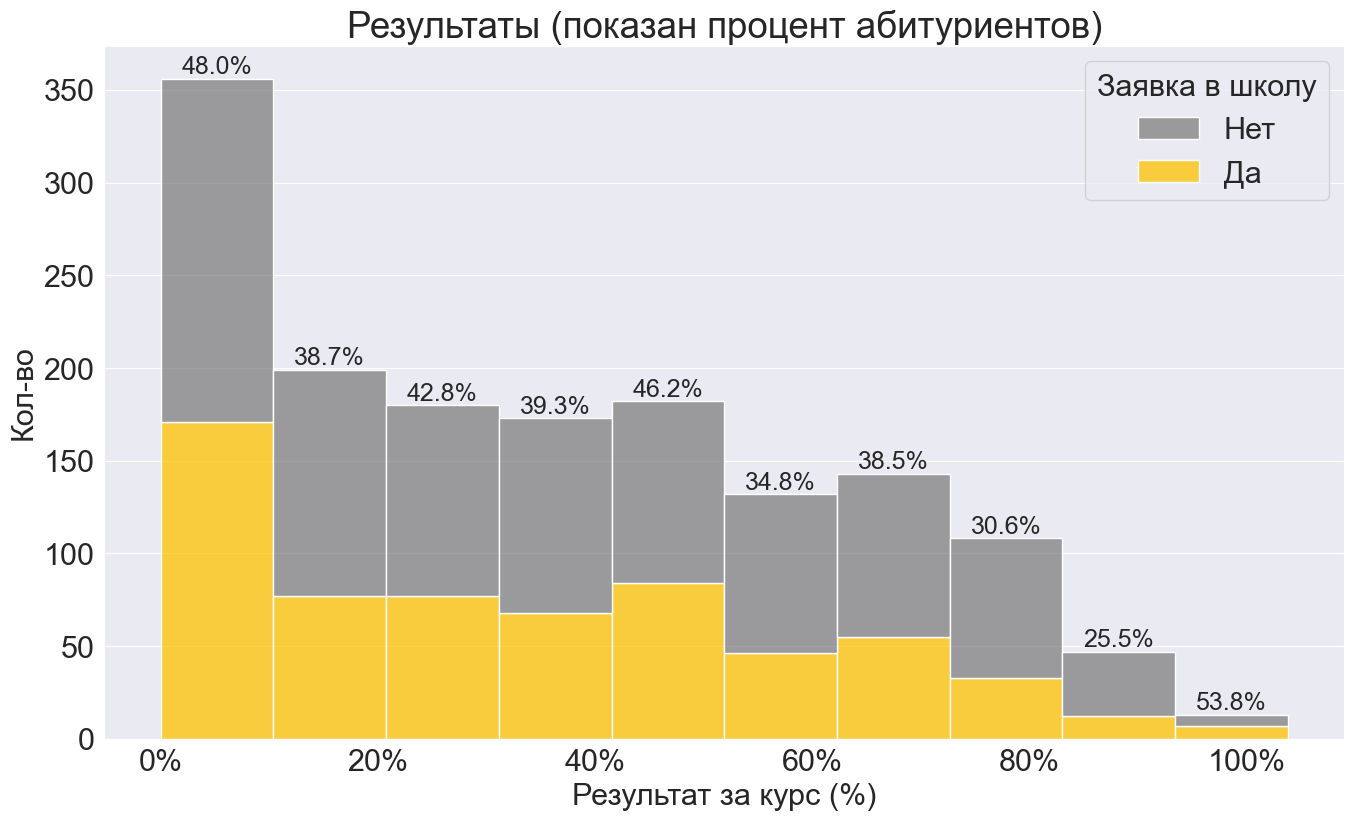

In [19]:
def histplot_hue_percent(data, x, hue, title=None, xlabel=None, ylabel=None, hue_legend_labels=None, hue_legend_title=None, palette=None, bins=10):    
    ax = sns.histplot(data=data, x=x, hue=hue, palette=palette, multiple='stack', bins=bins)
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
    percents = [f'{x.get_height() / (x.get_height() + y.get_height()):.1%}' if x.get_height()!=0 else '' for x, y  in zip(ax.containers[0], ax.containers[1])]
    ax.bar_label(ax.containers[1], percents, fontsize=18)
    
    plt.grid(axis='x')
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if hue_legend_labels:
        legend = ax.get_legend()
        handles = legend.legendHandles
        labels = hue_legend_labels
        ax.legend(handles, labels, title=hue_legend_title)
    return ax
histplot_hue_percent(data=df_start, x='percent_score', hue='school_app', palette=palette_dict,
                     title='Результаты (показан процент абитуриентов)', 
                     xlabel='Результат за курс (%)', ylabel='Кол-во',
                     hue_legend_labels=['Нет', 'Да'], hue_legend_title='Заявка в школу')
plt.show()

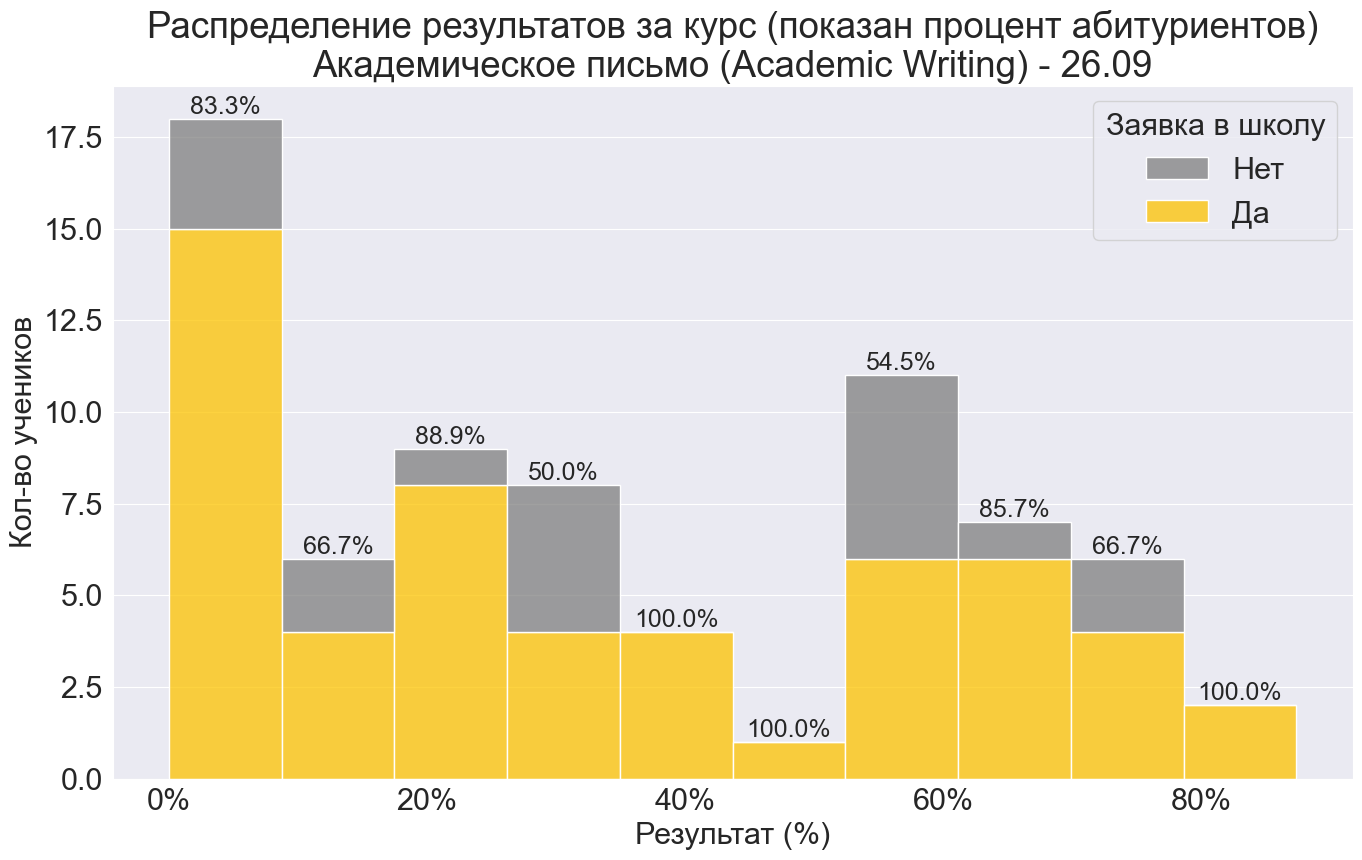

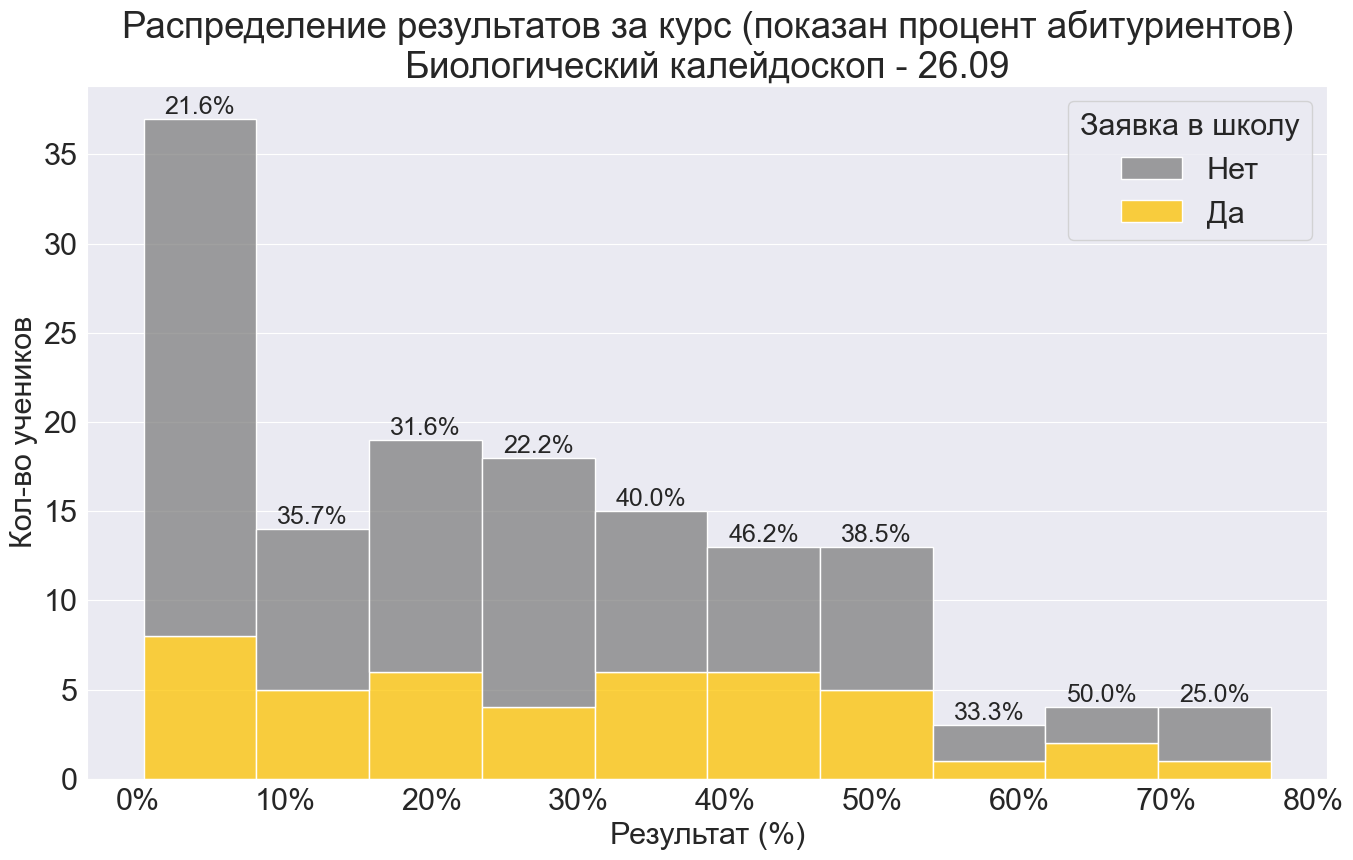

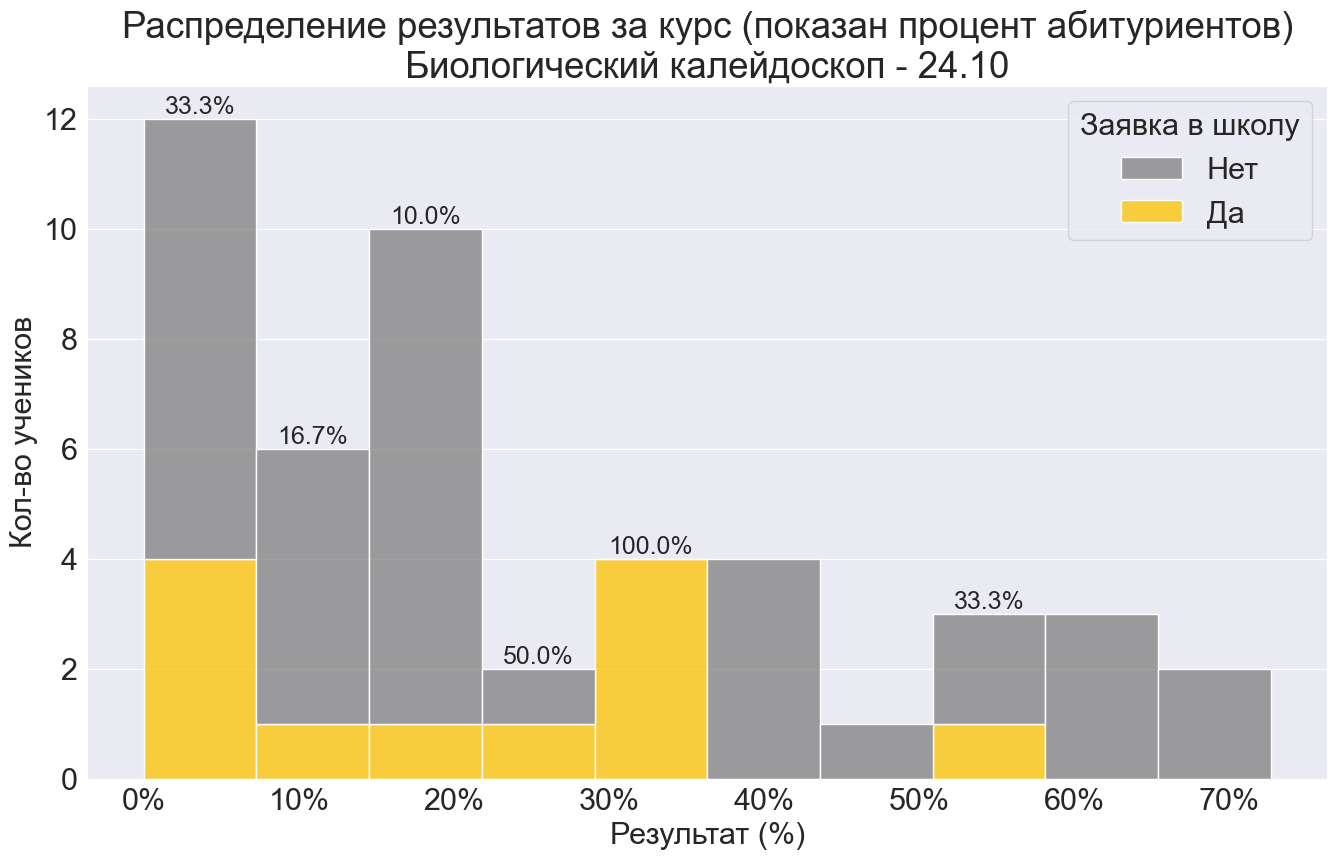

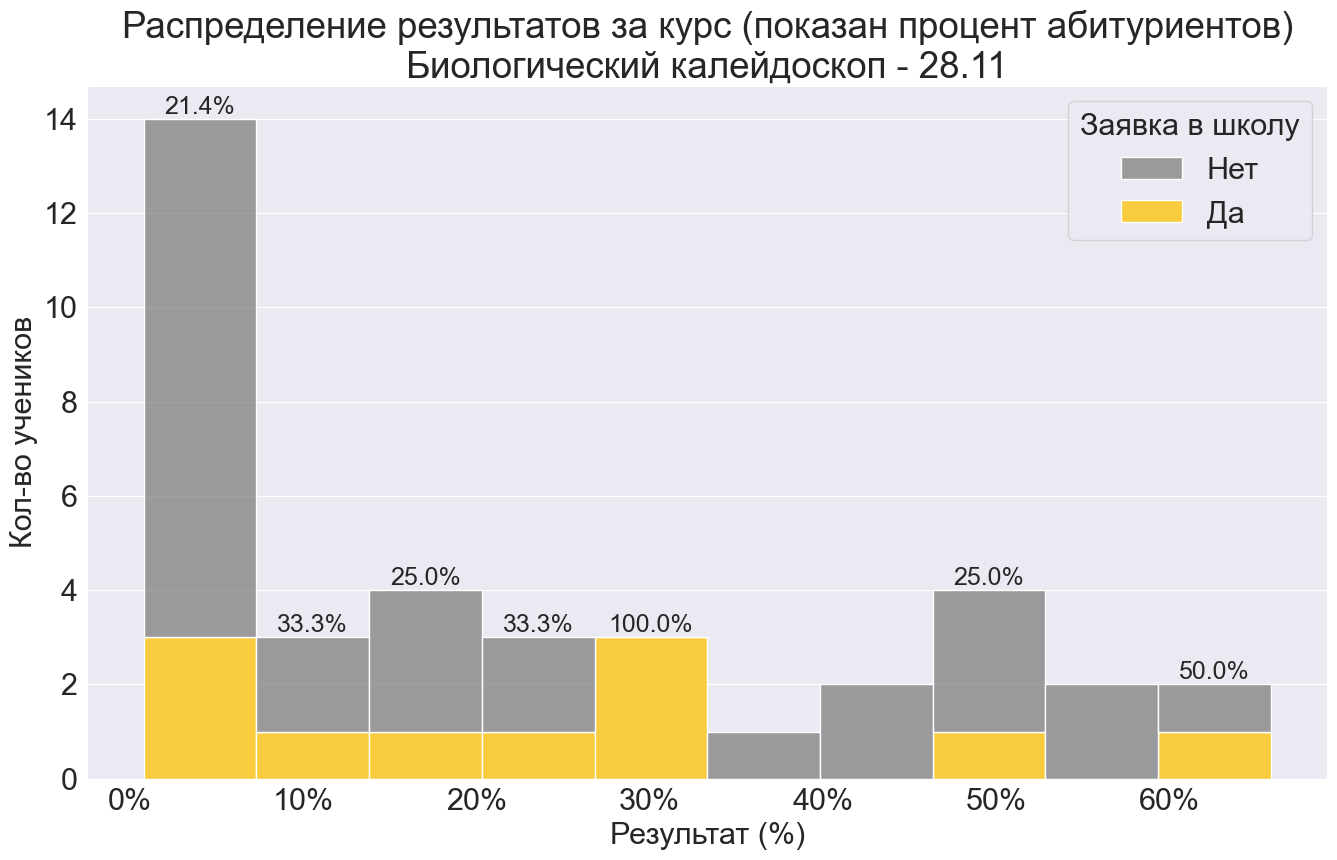

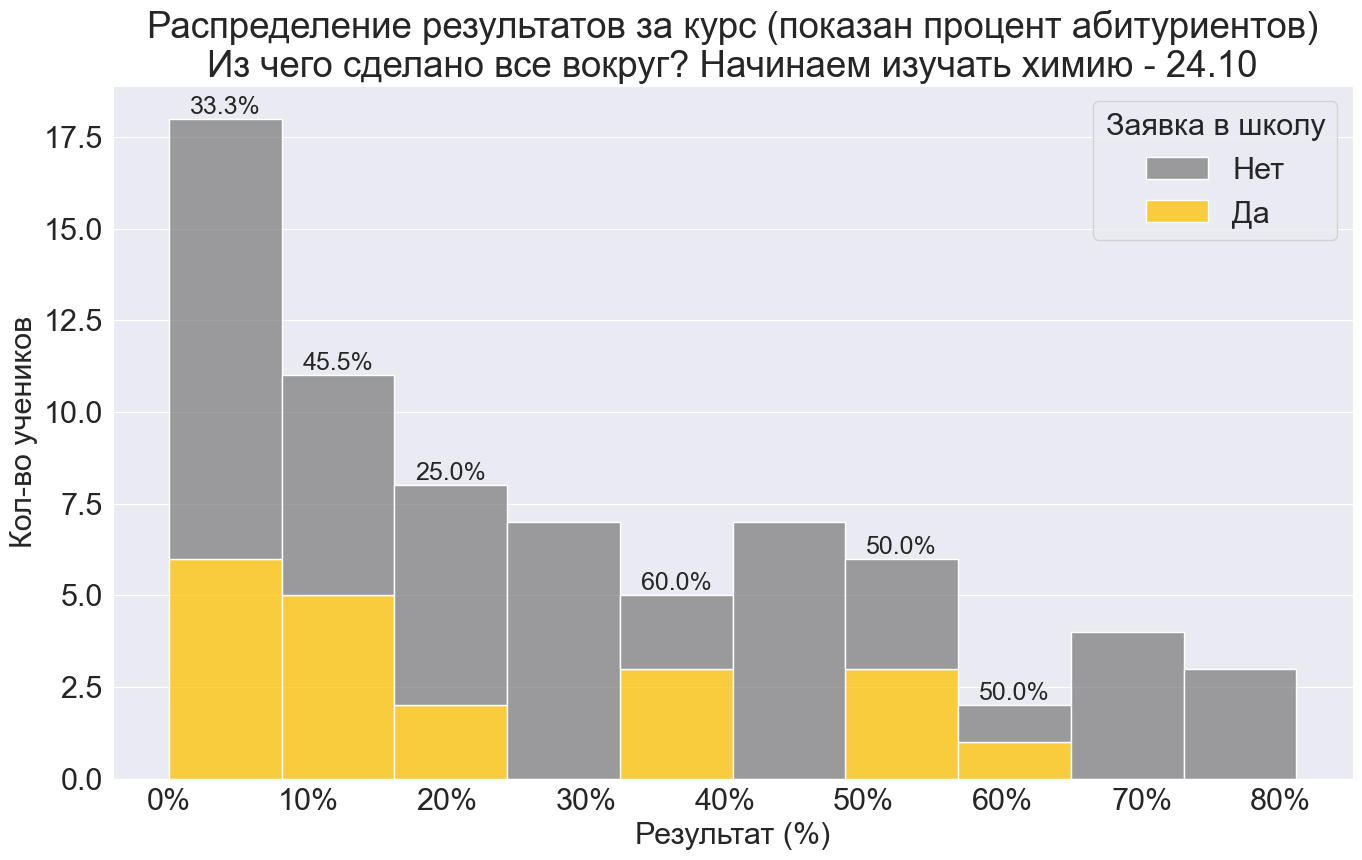

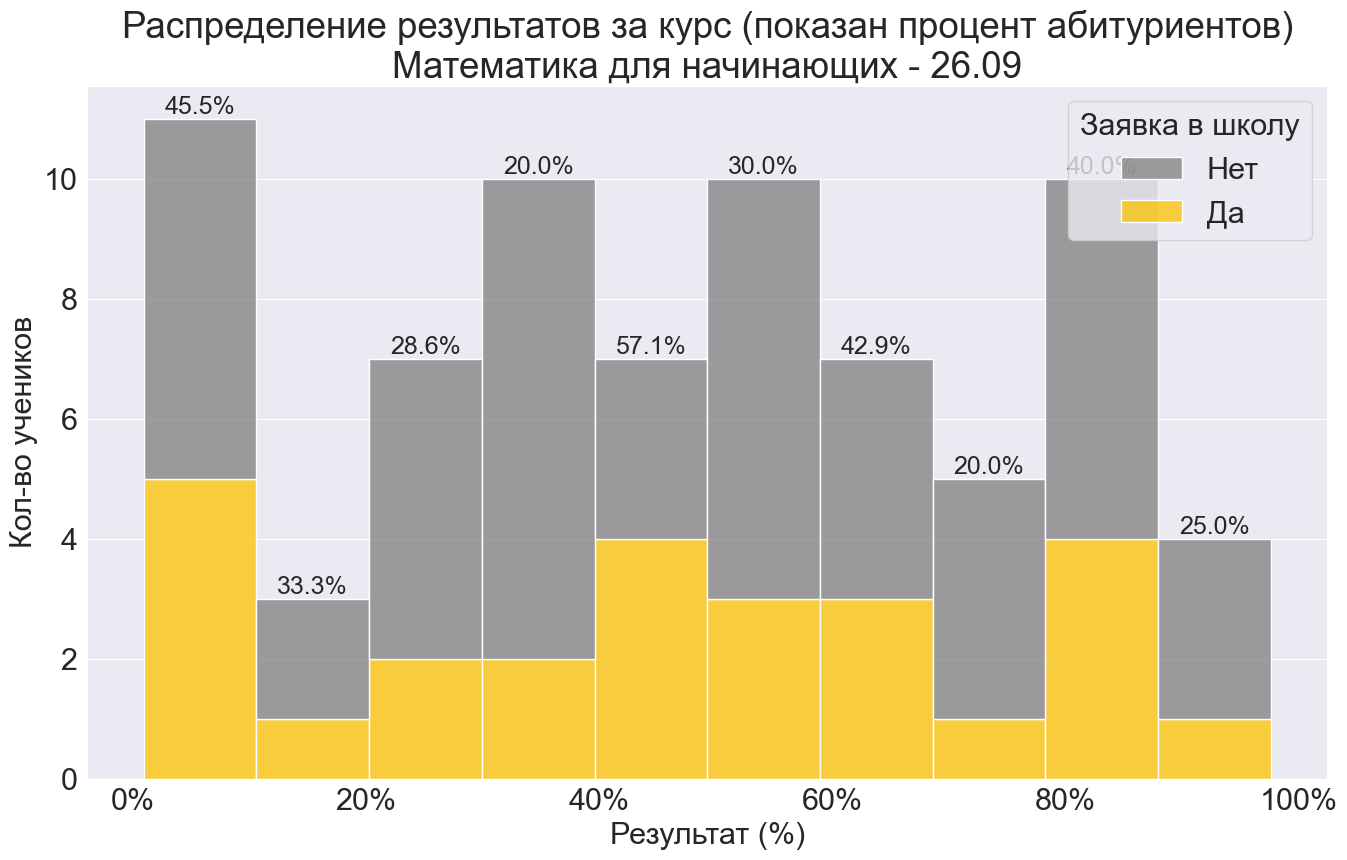

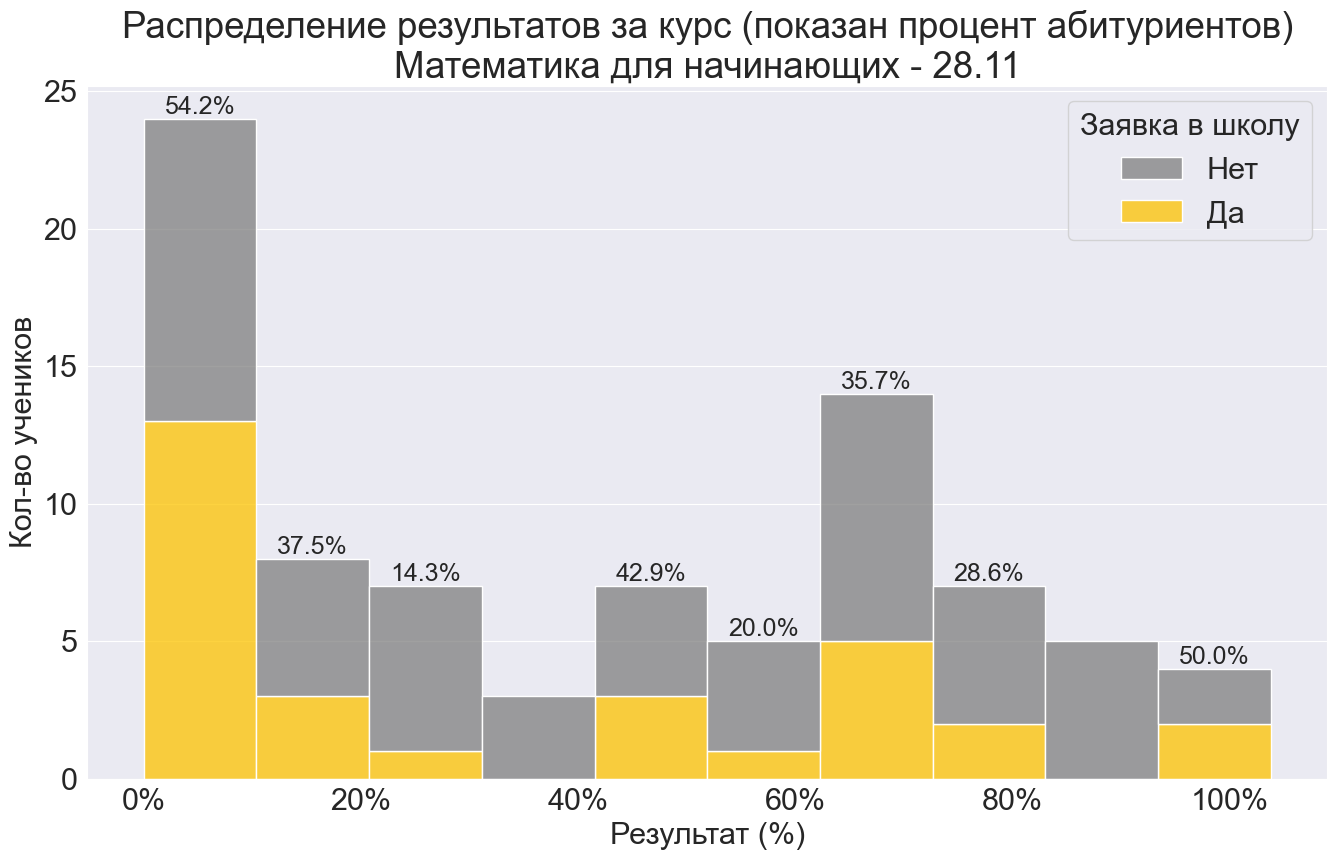

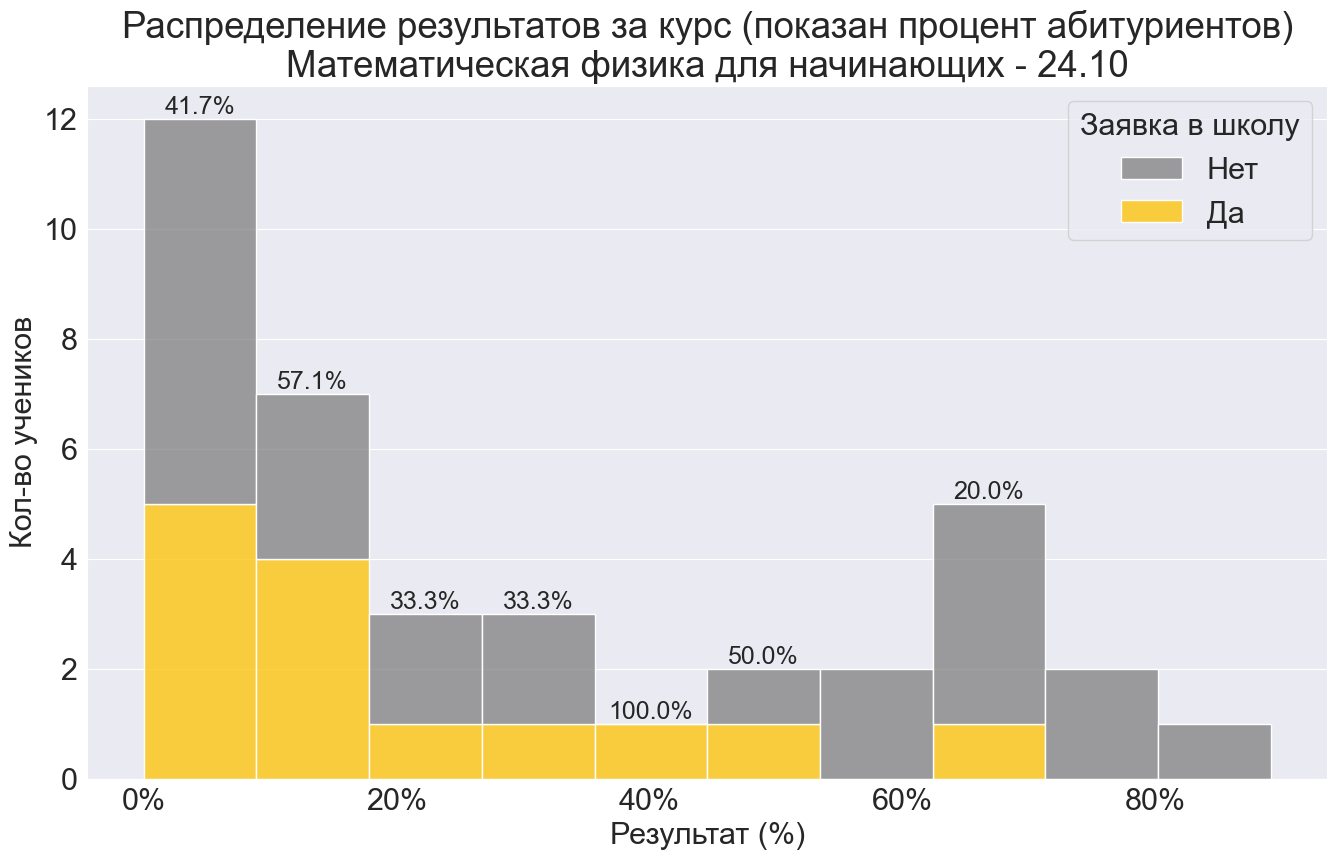

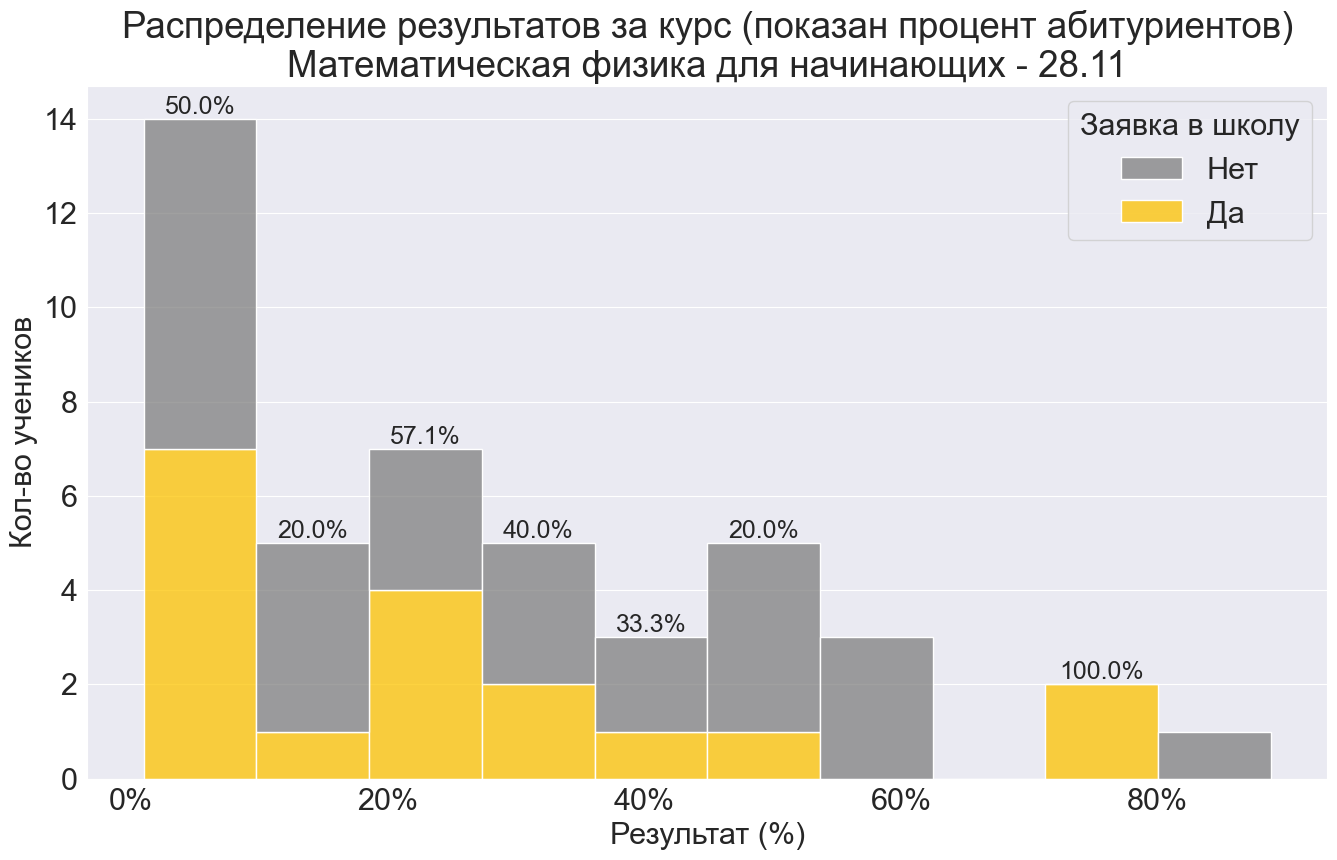

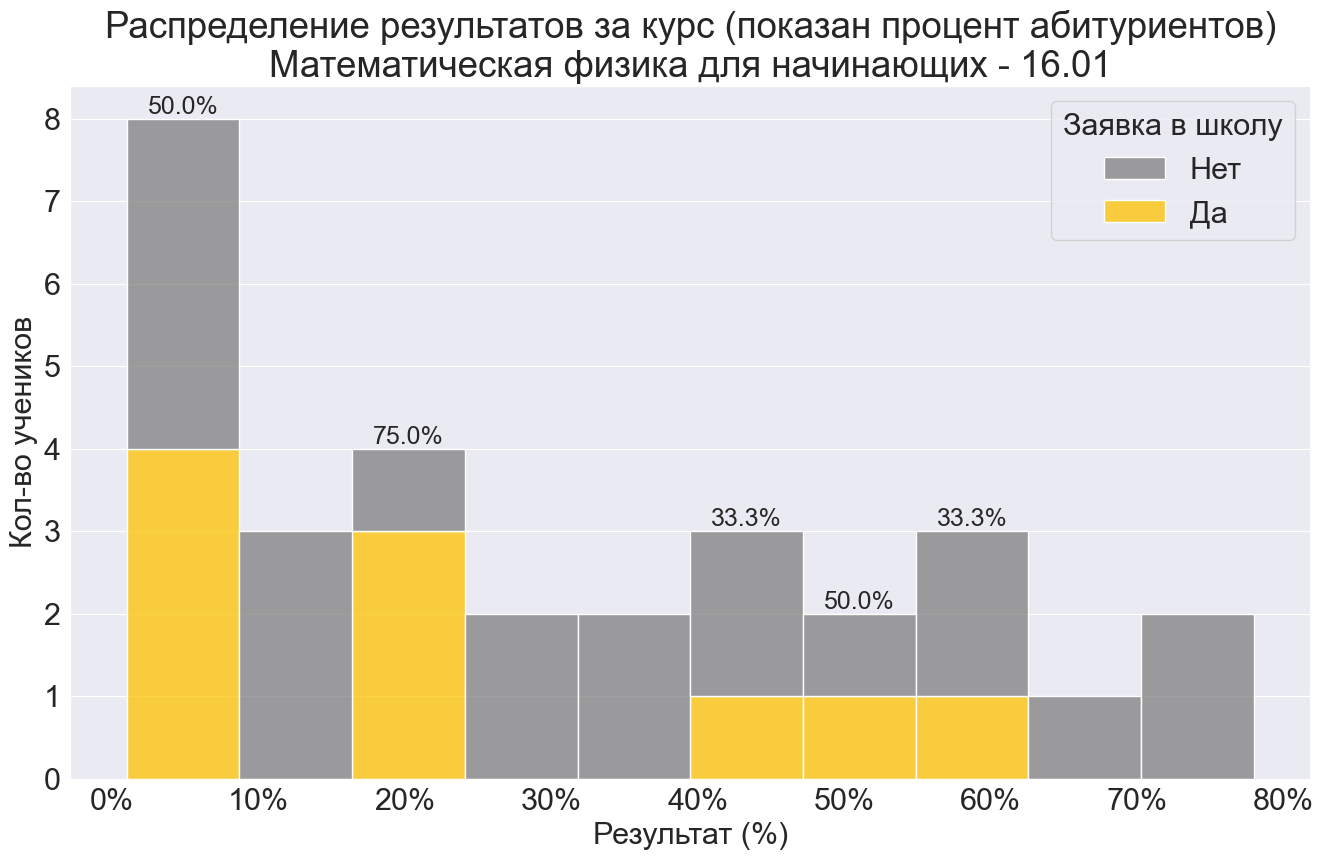

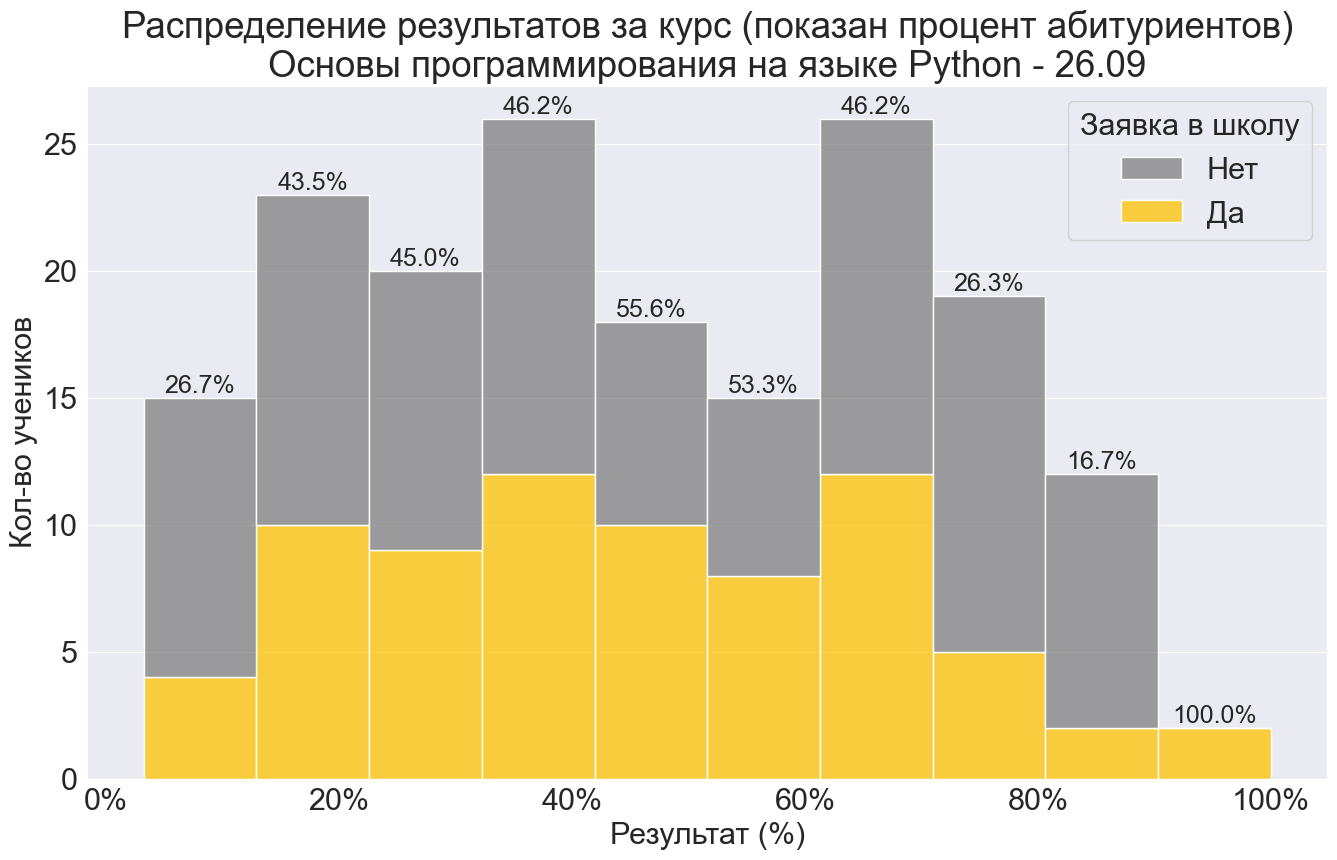

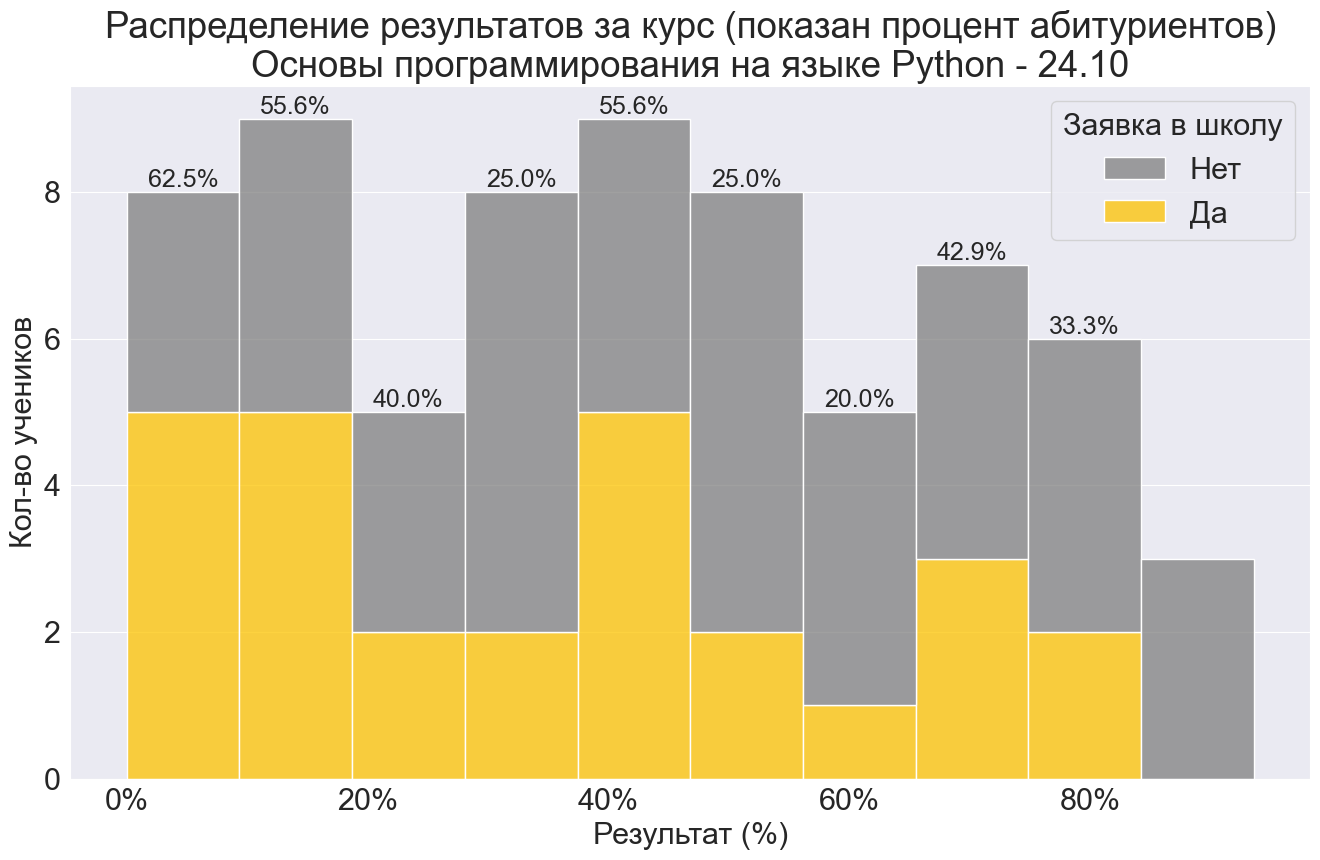

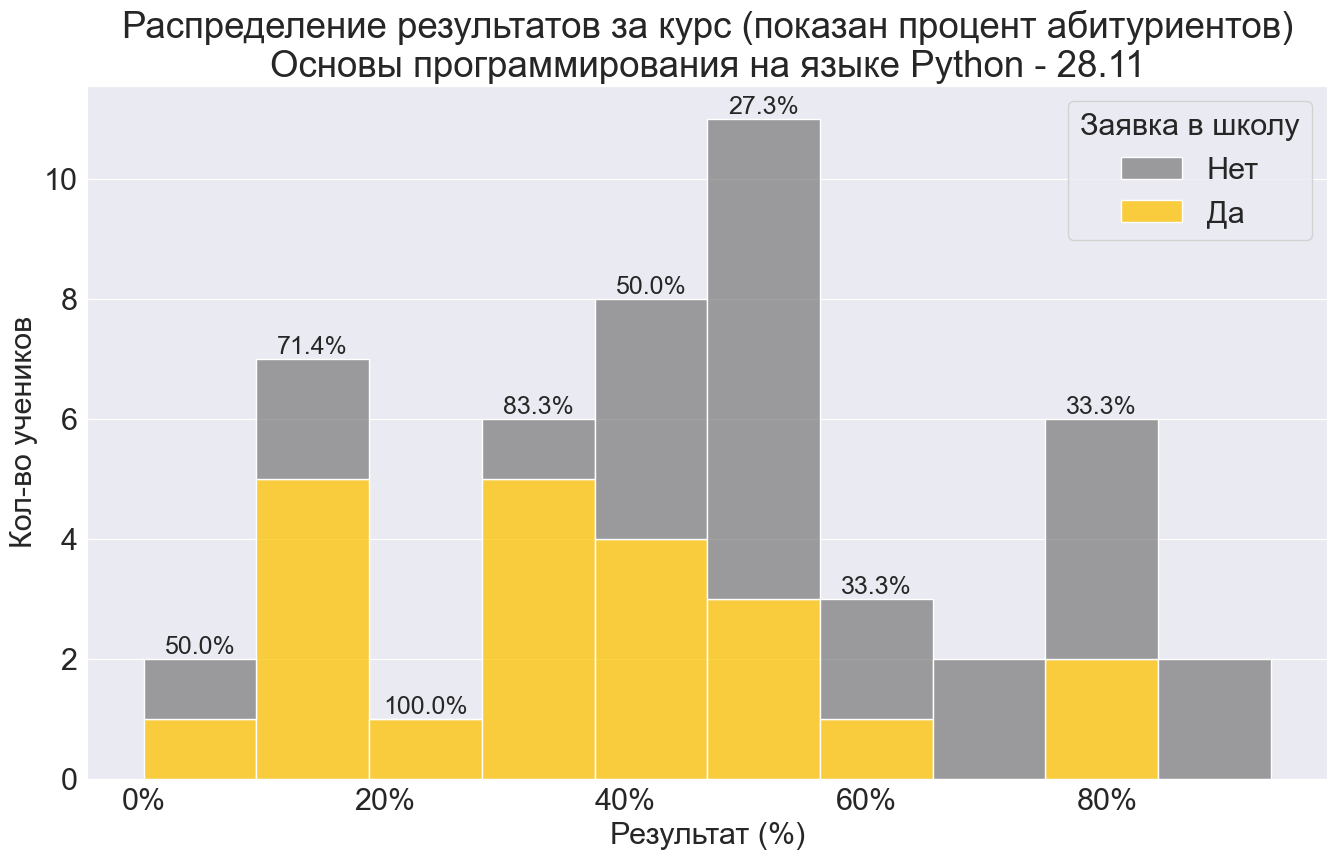

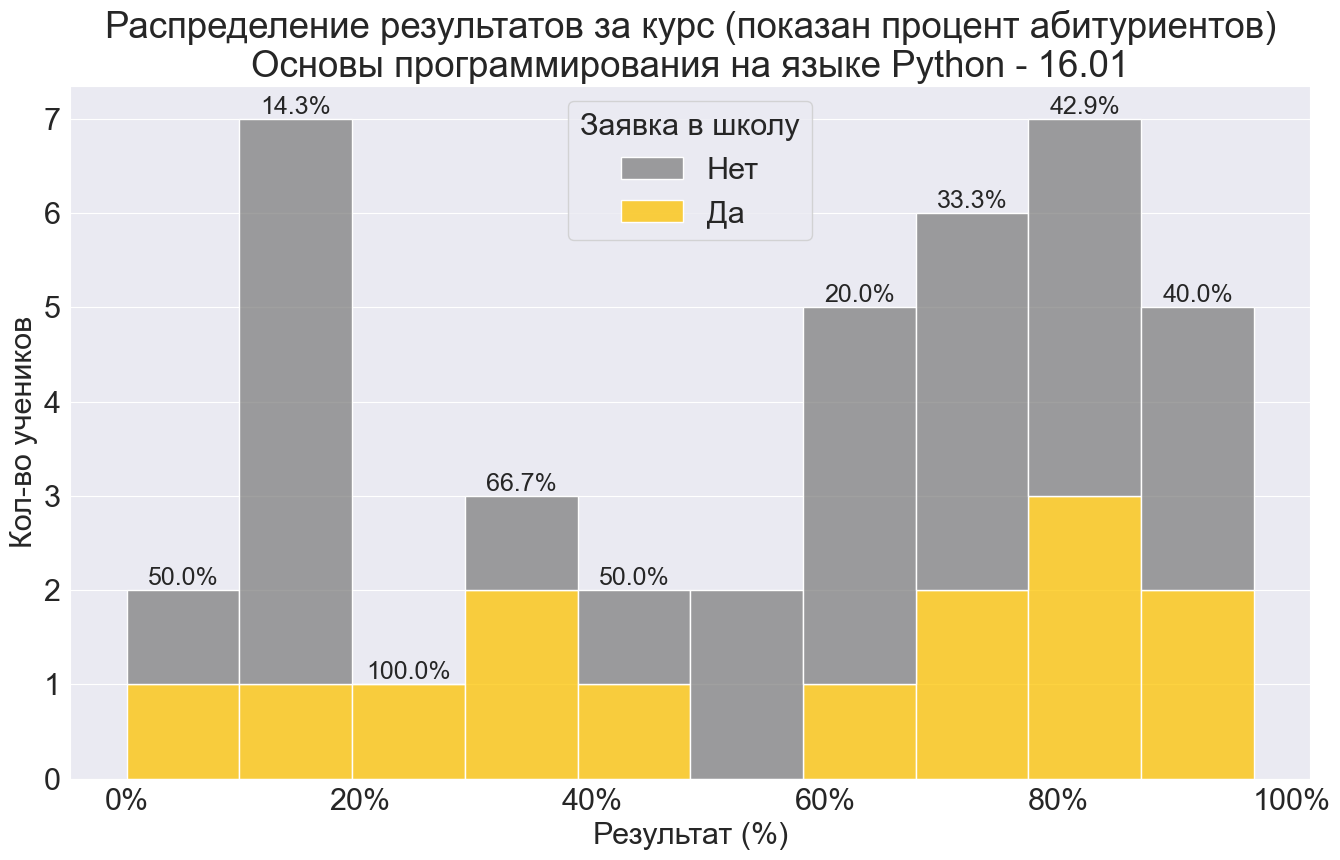

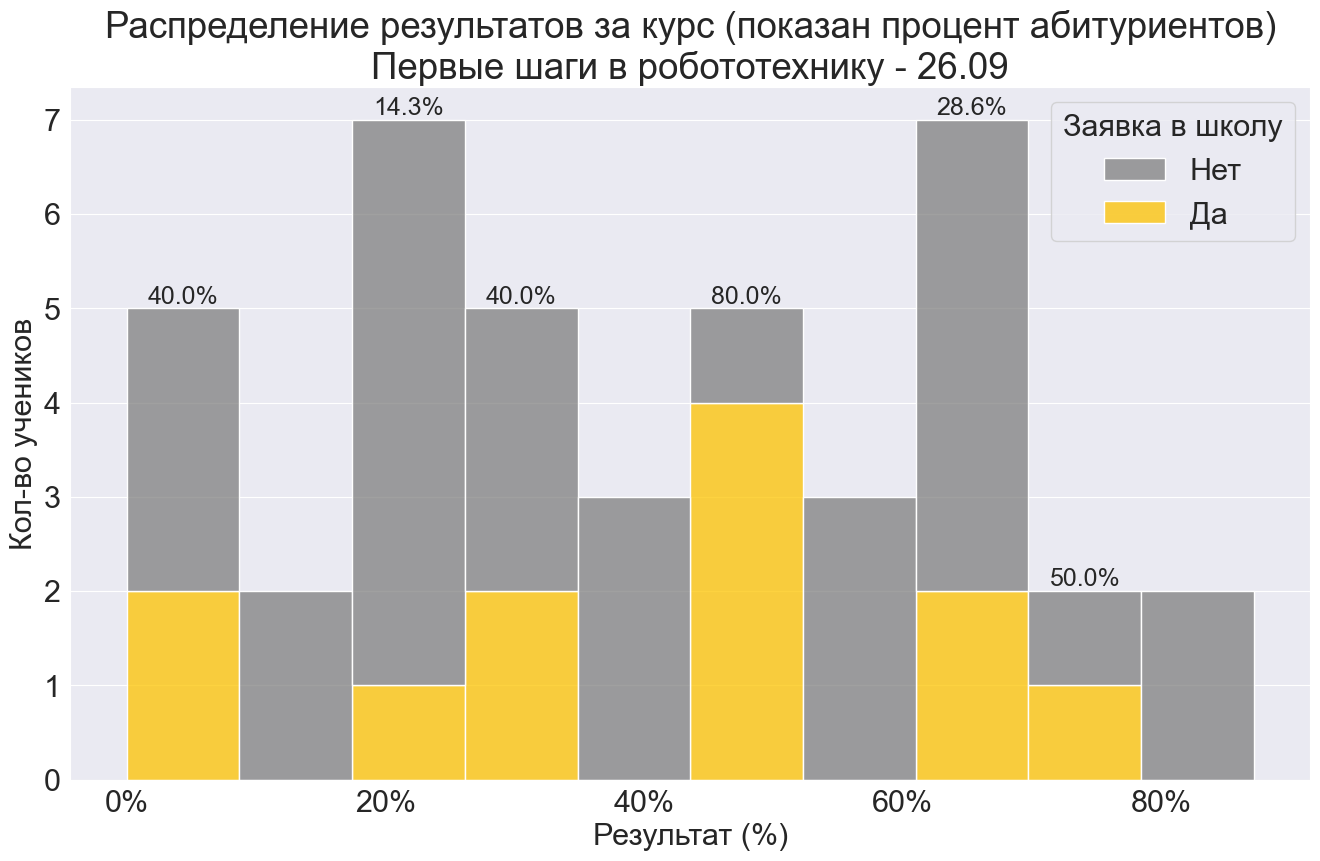

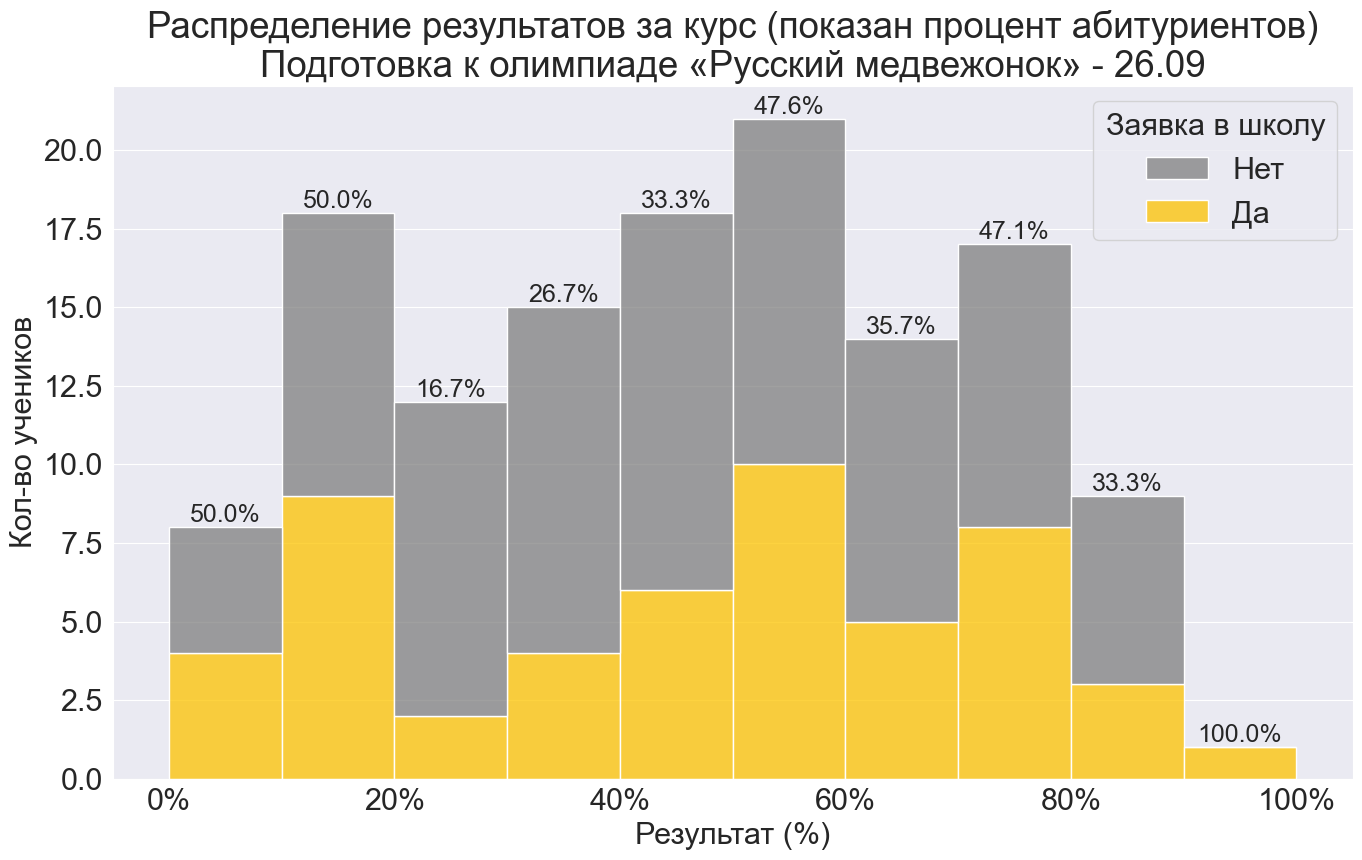

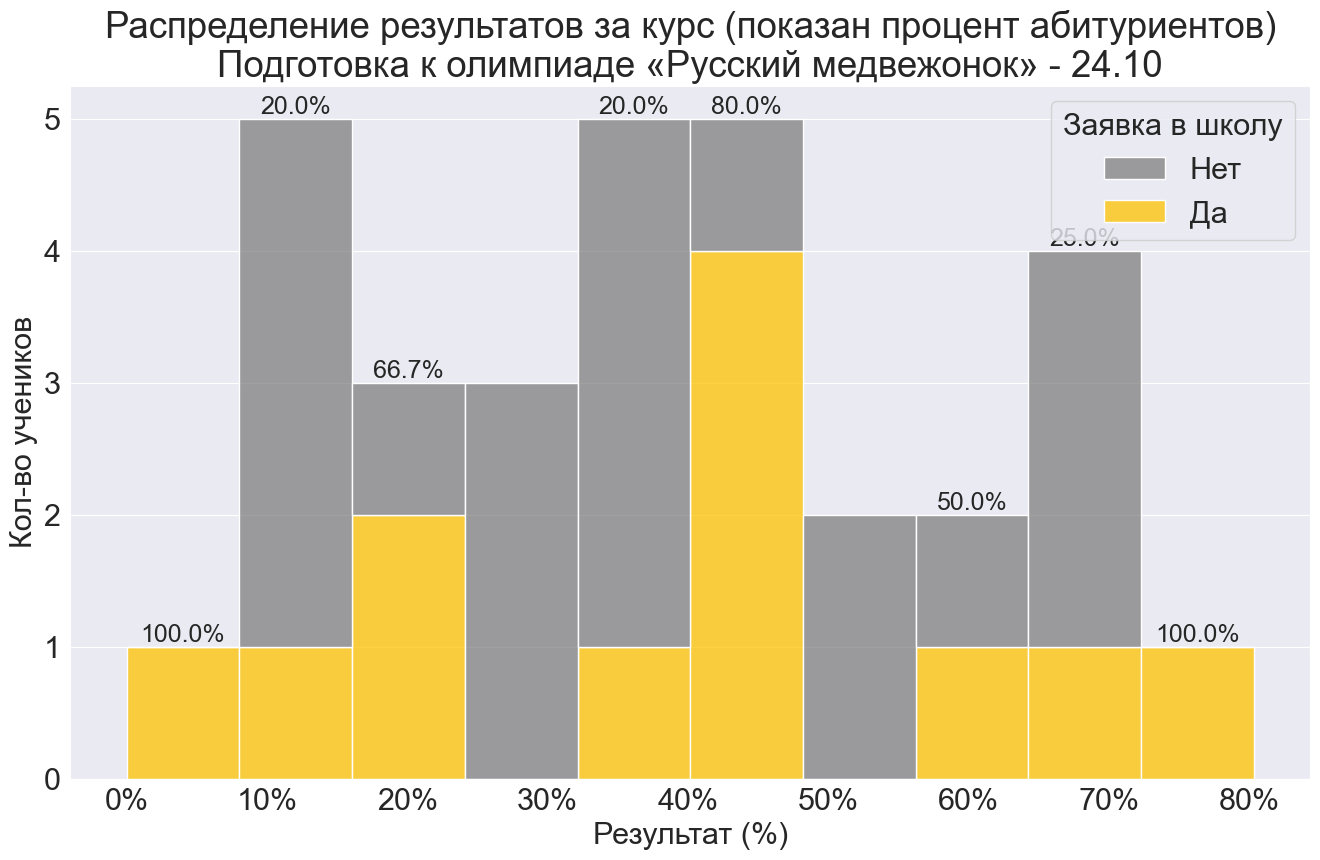

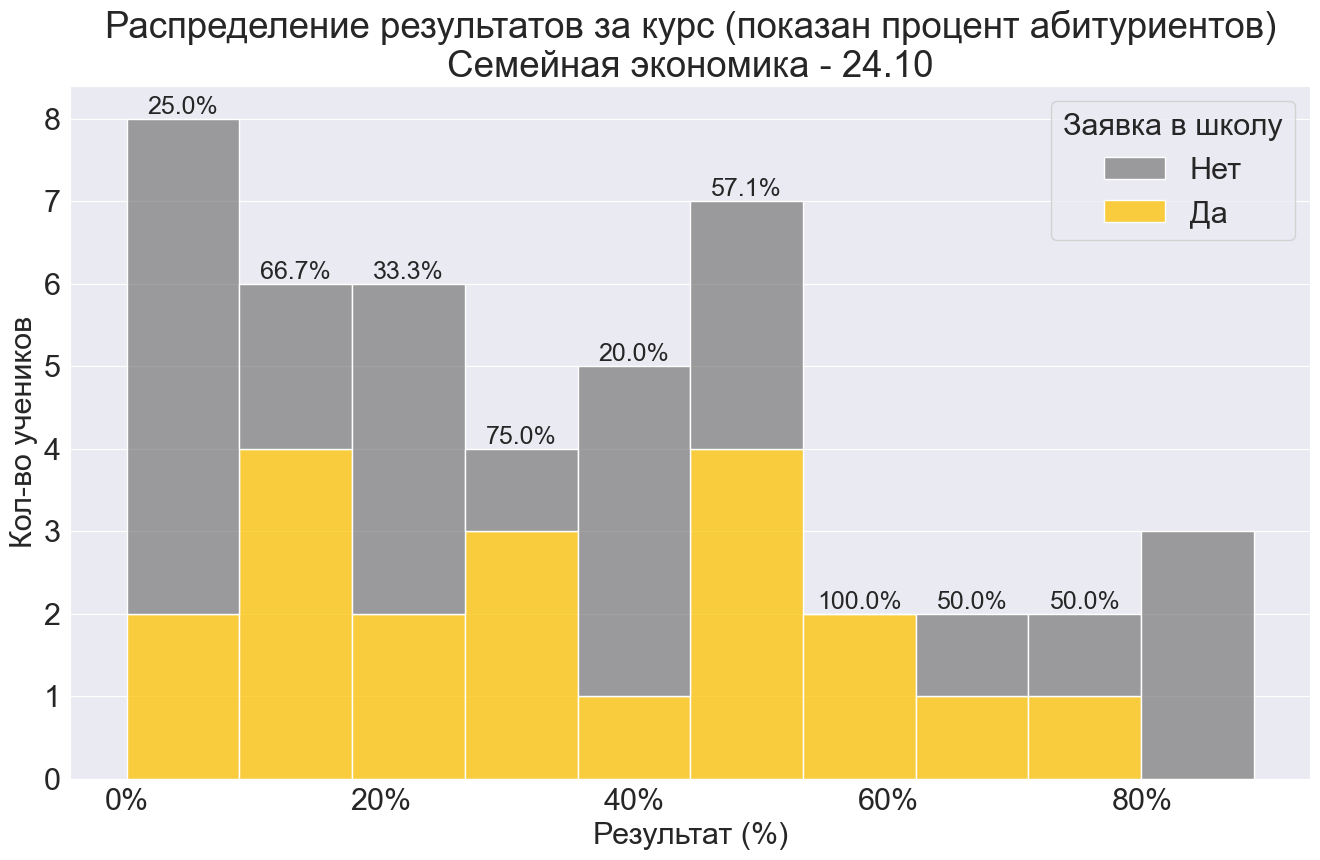

In [20]:
for course, group in course_group:
    if course_info_fin.loc[(course, group), 'Приступили'] >= 30:
        data = df_start[(df_start.course_name == course) & (df_start.group_name == group)]
        if data.shape[0] != 0:
            histplot_hue_percent(data=data, x='percent_score', hue='school_app',
                                 title = f'Распределение результатов за курс (показан процент абитуриентов)\n{course} - {group}',
                                 xlabel='Результат (%)', ylabel='Кол-во учеников',
                                 palette=palette_dict,
                                 hue_legend_title='Заявка в школу', hue_legend_labels=['Нет', 'Да'])
            plt.show()

### Бокс-плоты

In [21]:
courses = df_start.course_name.unique()

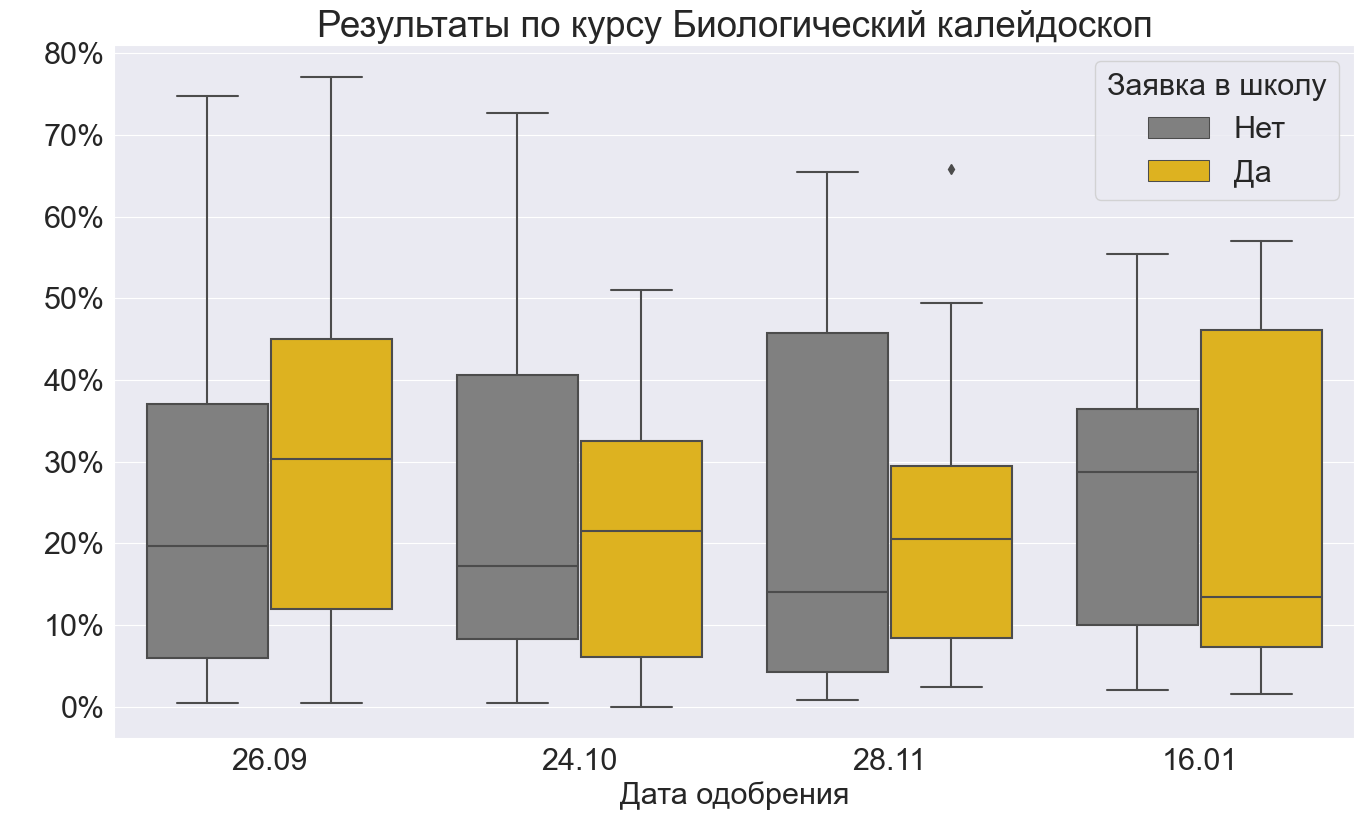

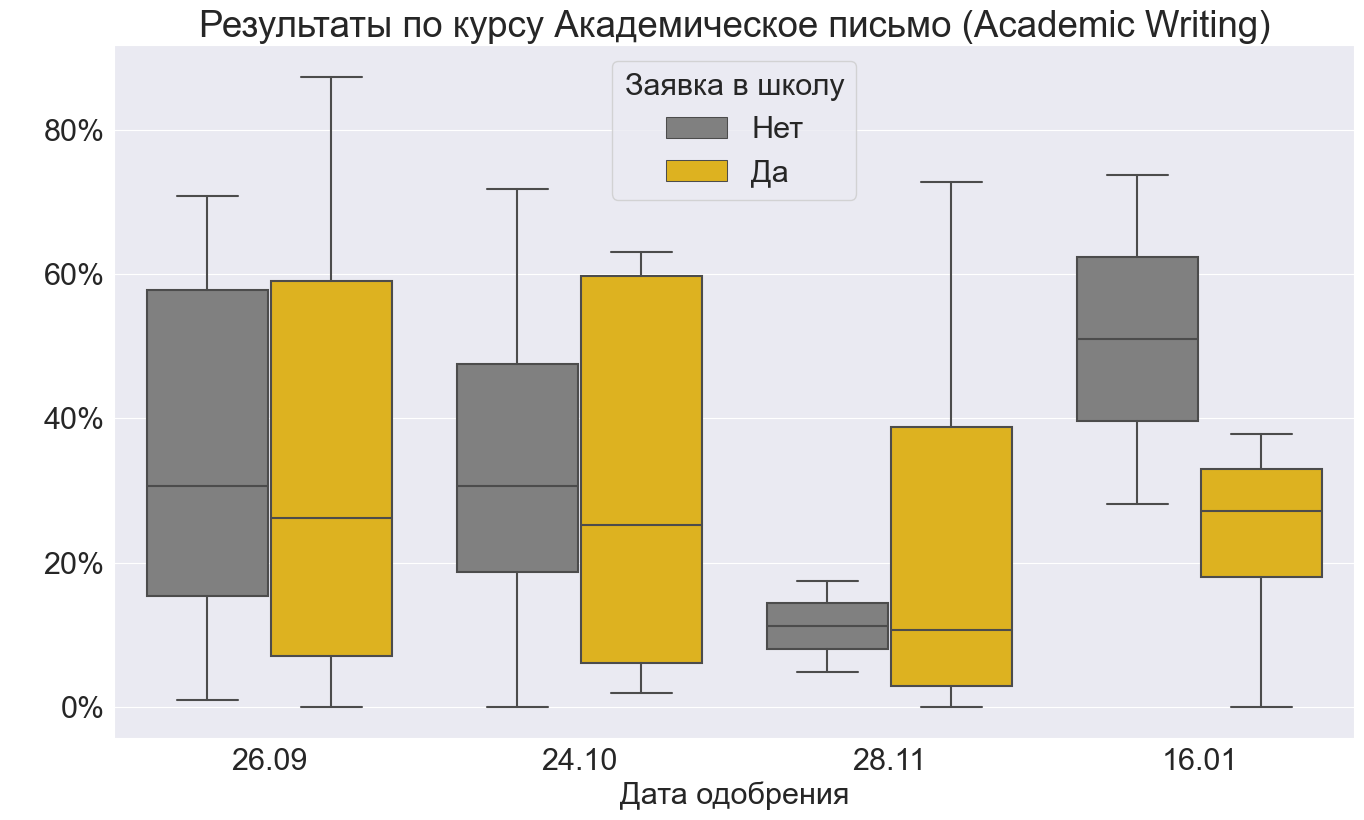

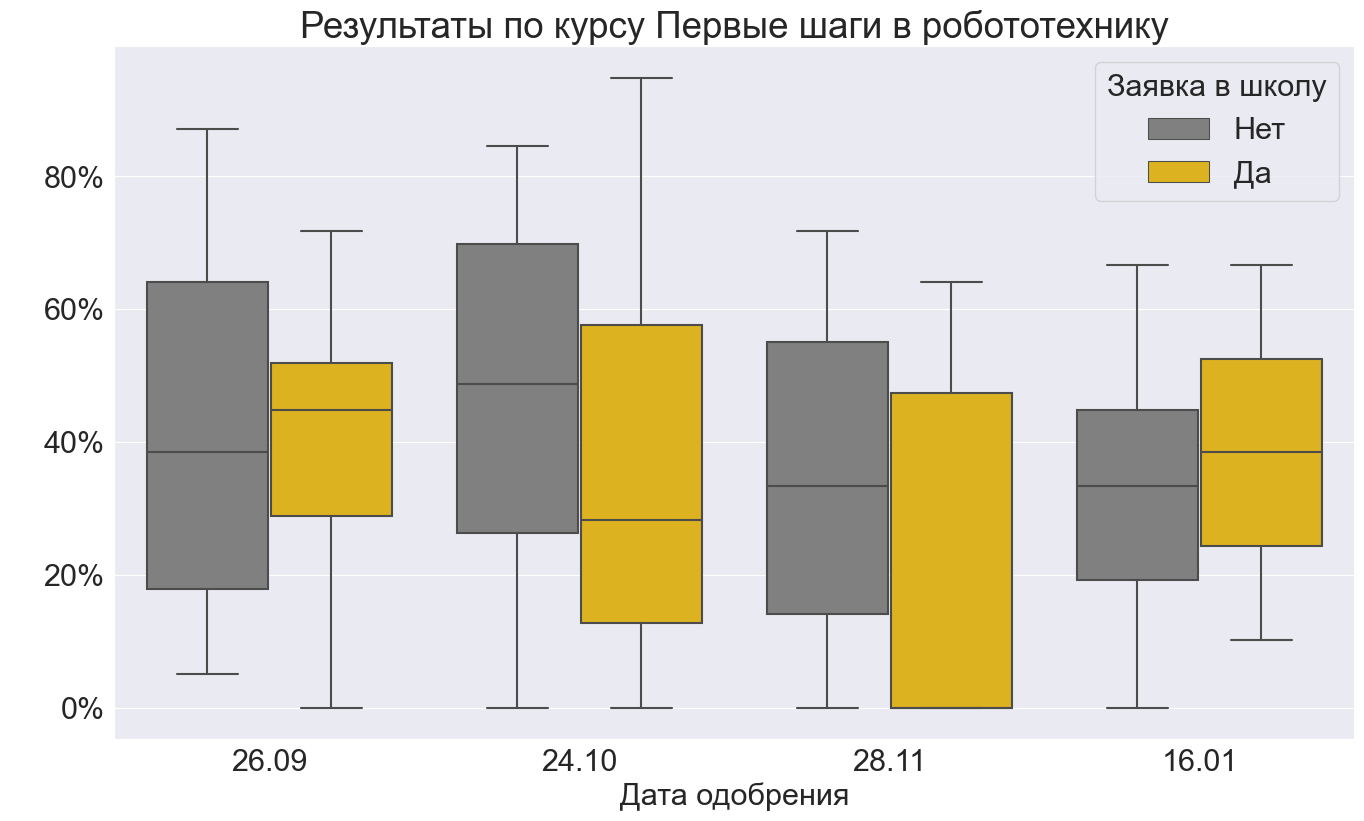

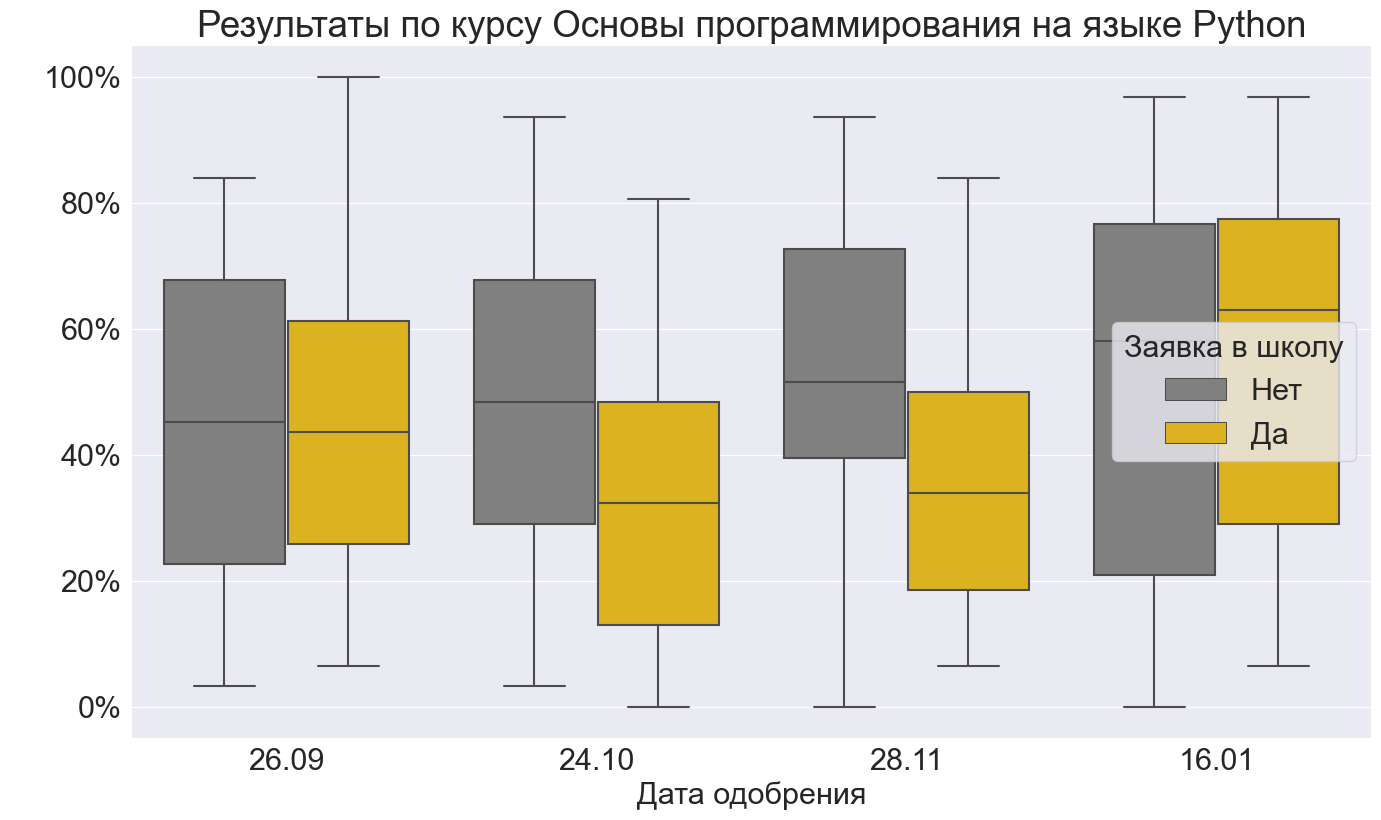

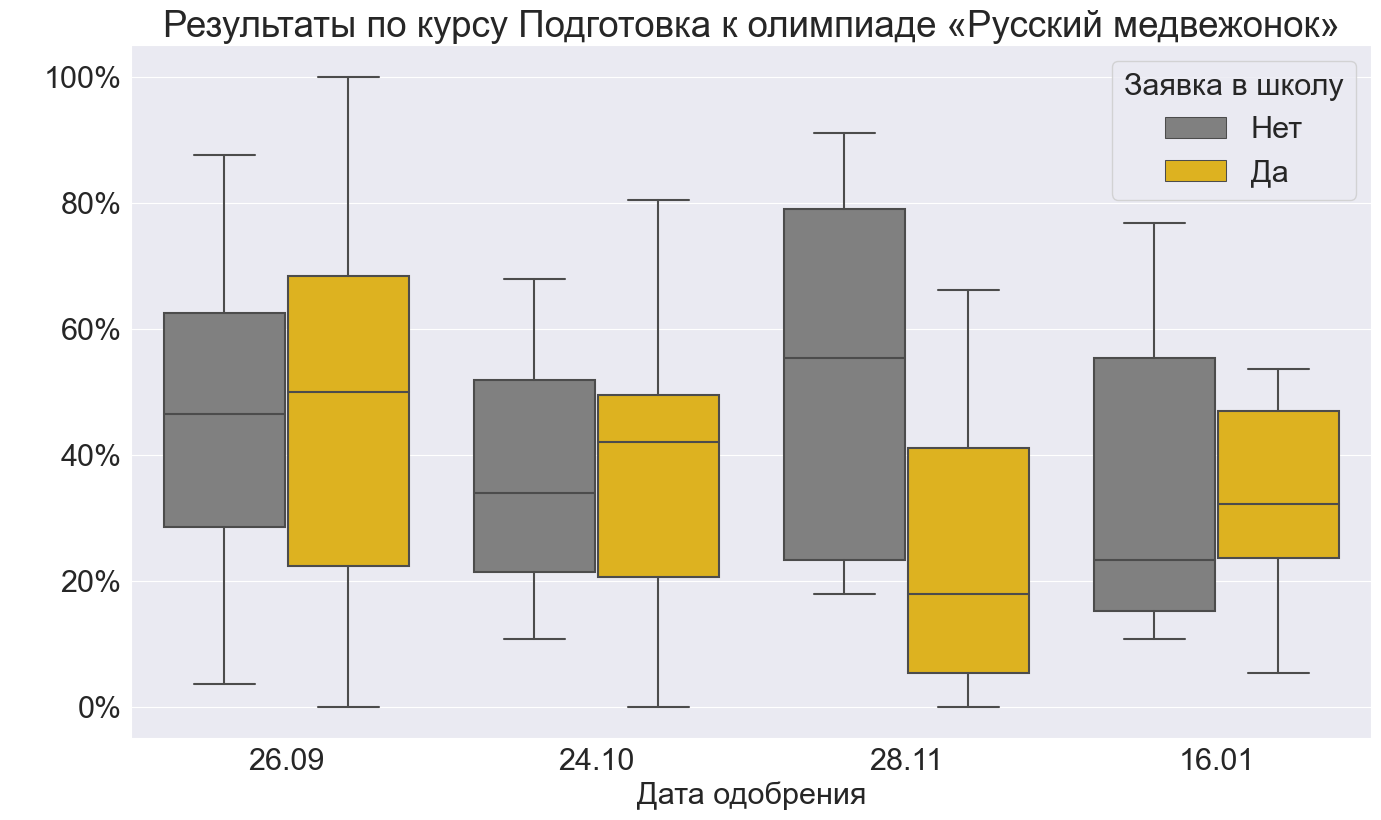

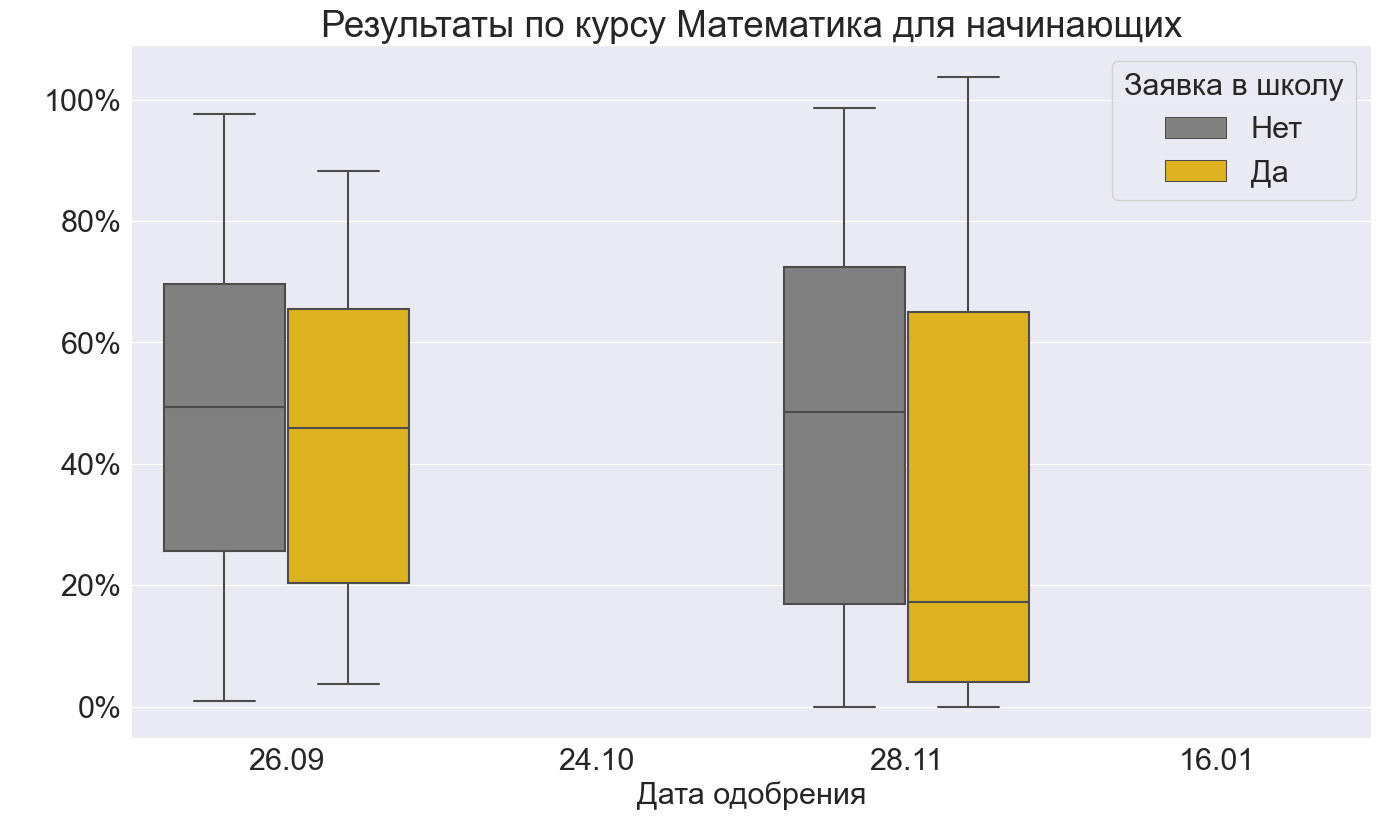

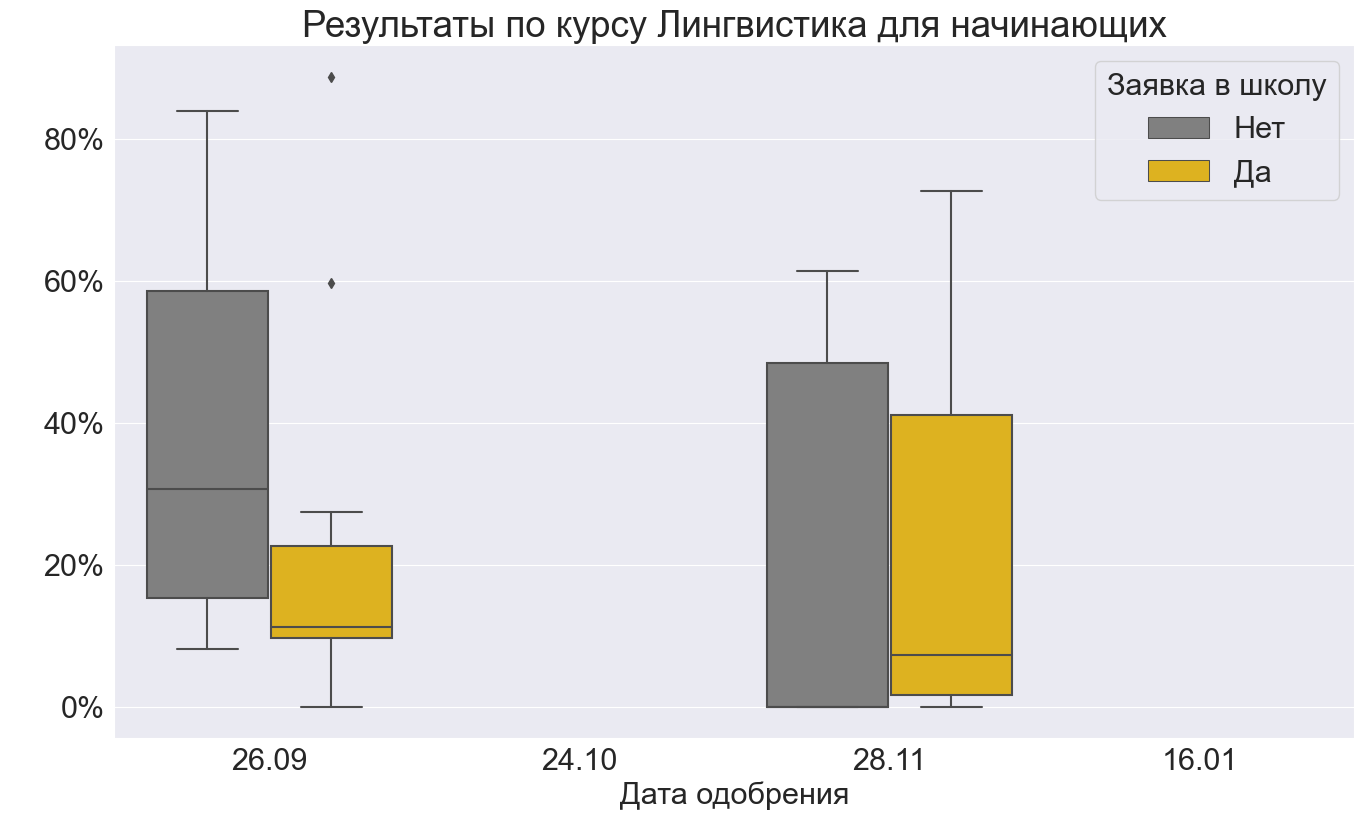

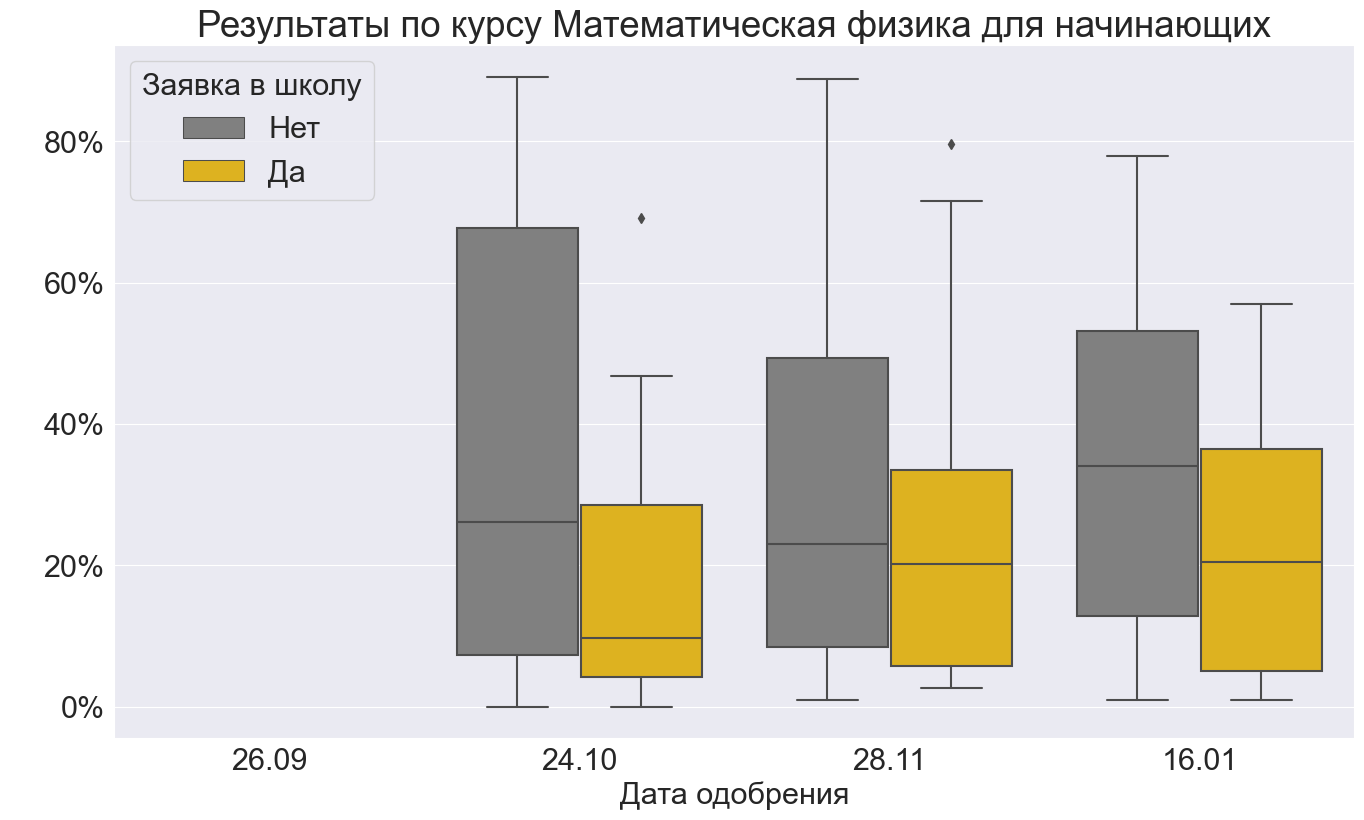

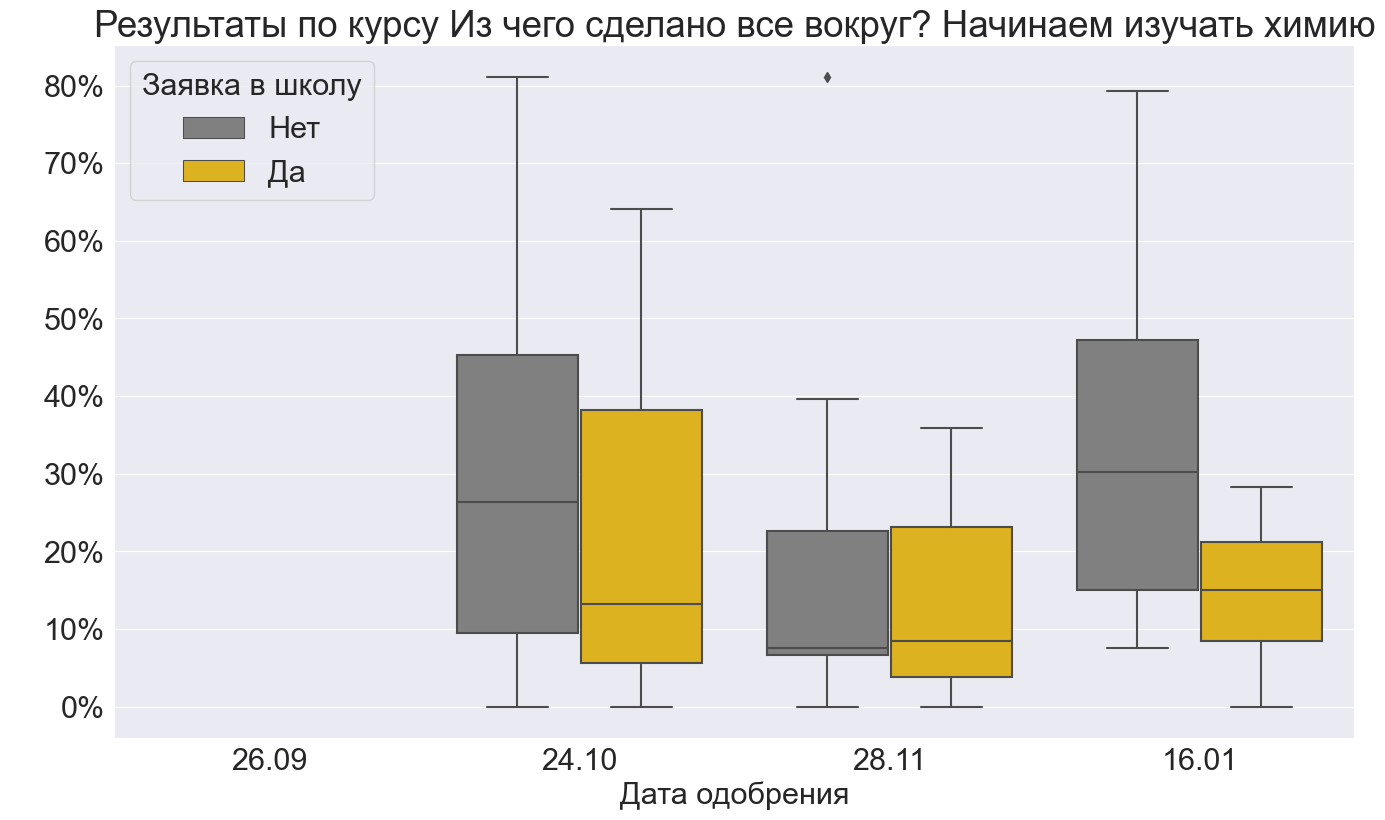

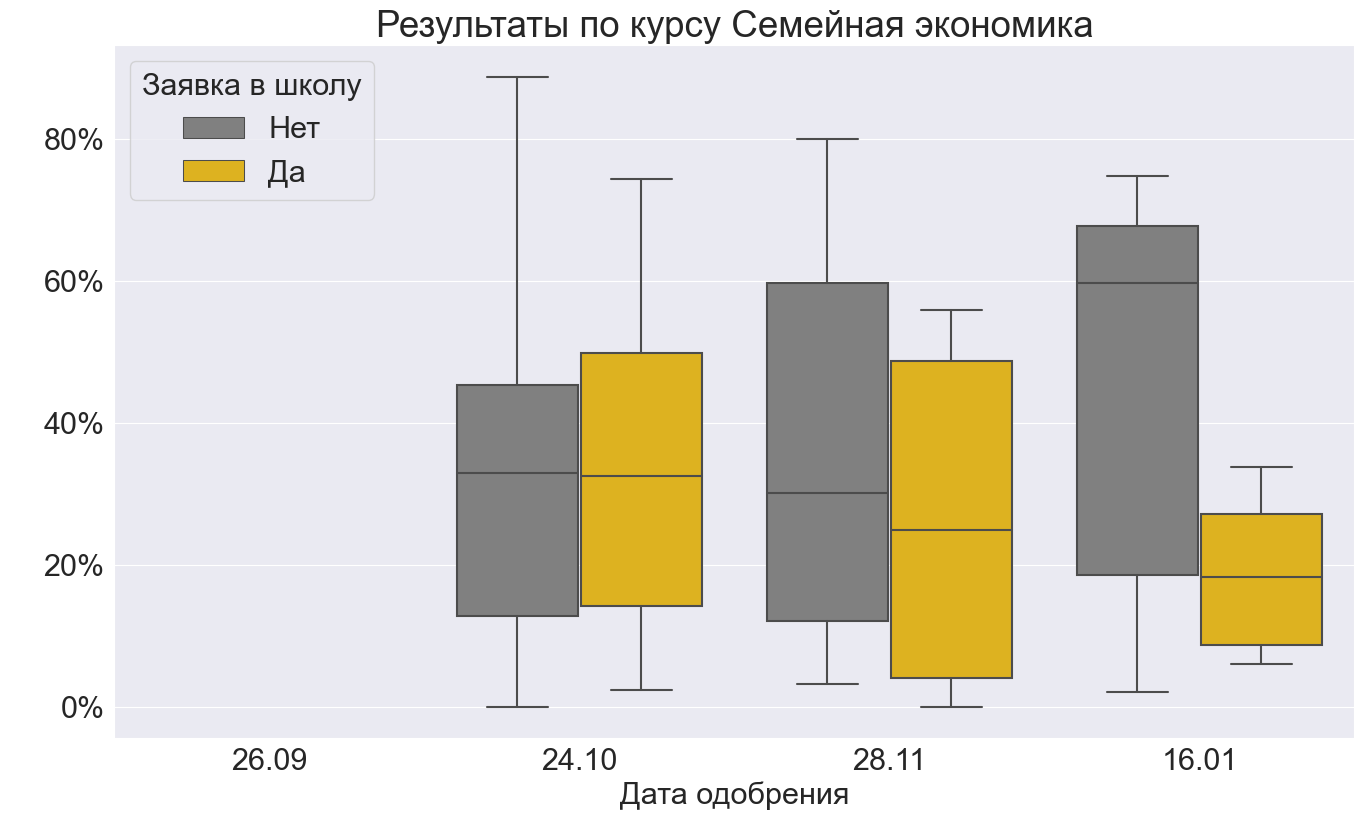

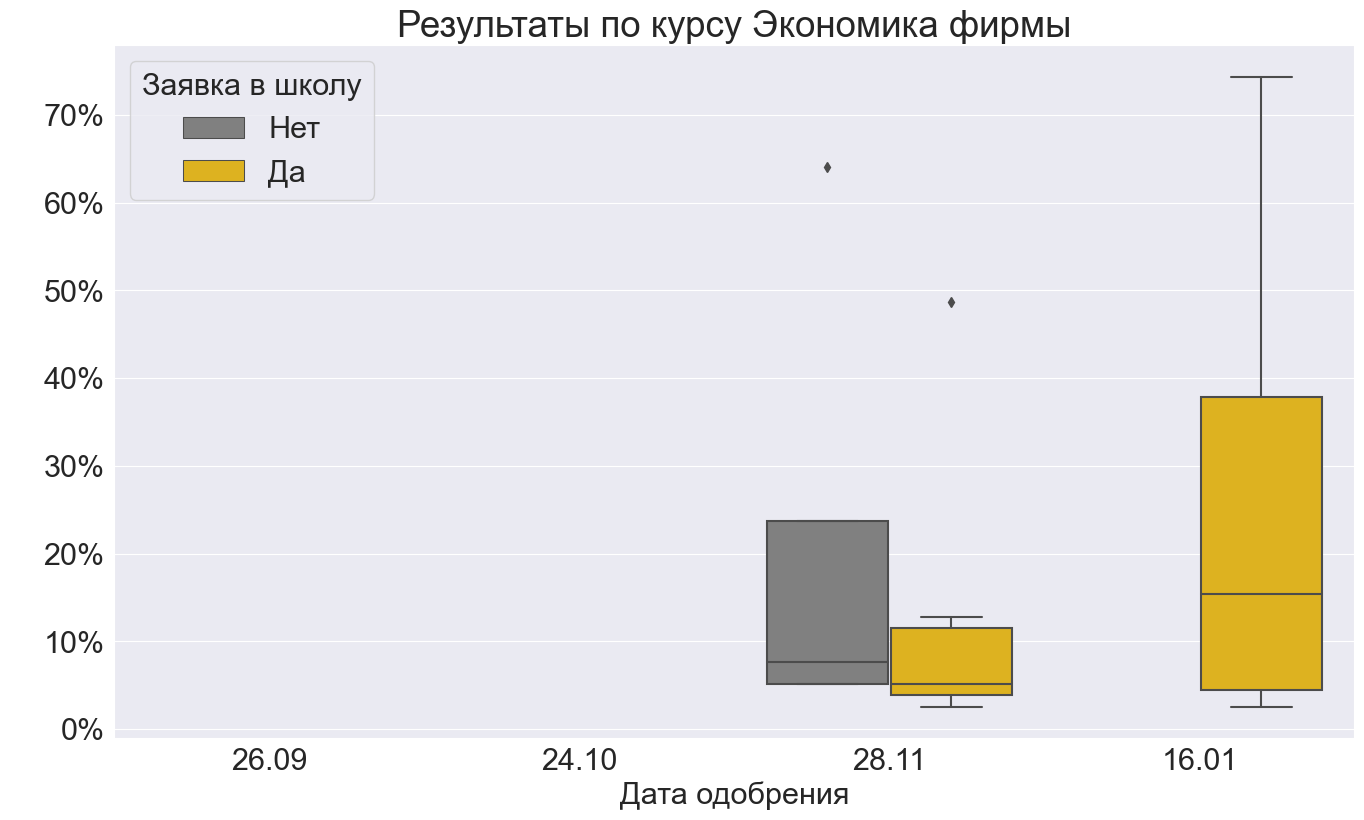

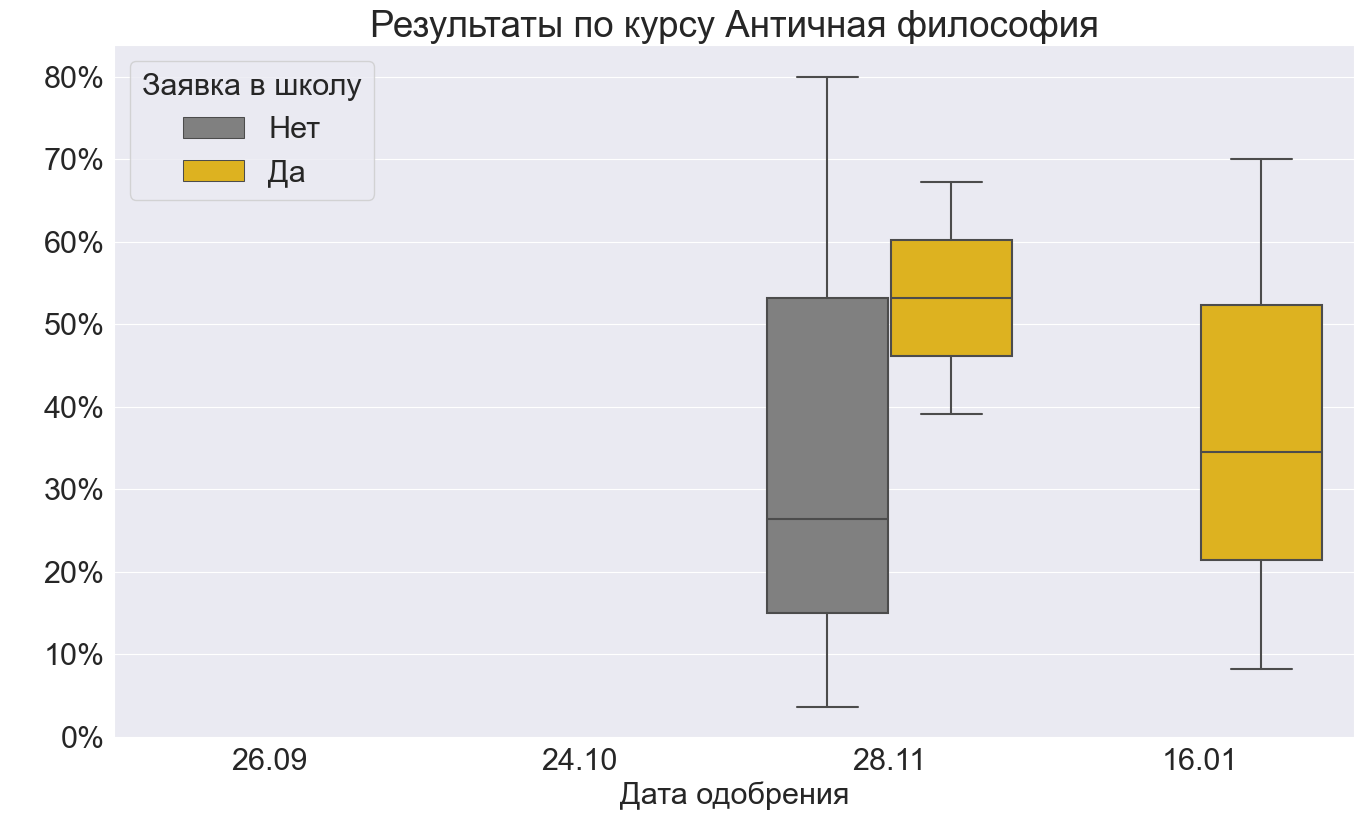

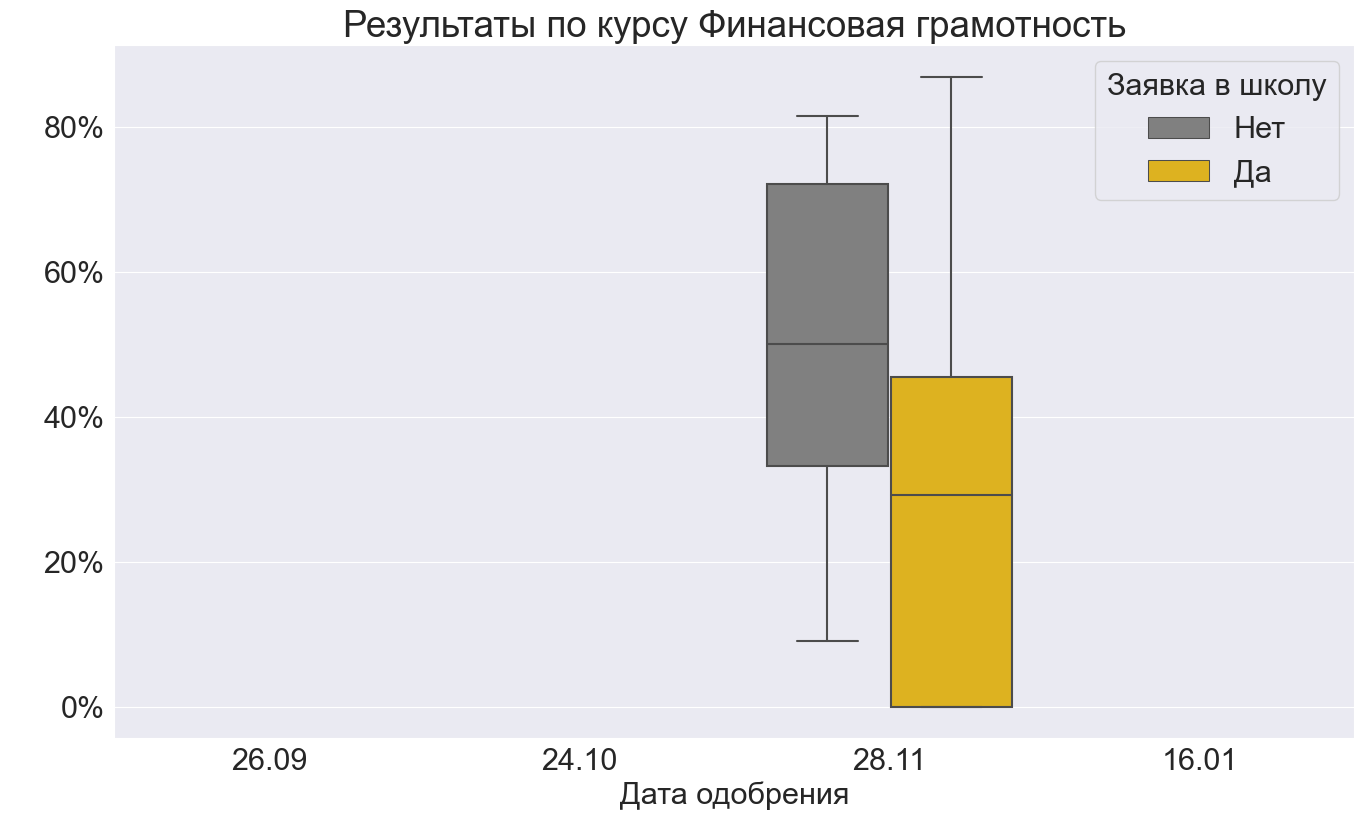

In [22]:
def continuous_by_groups_plot(df: pd.DataFrame, x: str, y: str, outliers=False,
                              title: str=None, xlabel: str=None, ylabel: str=None, palette='Set2',
                              hue: str=None, hue_legend_labels: str=None, hue_legend_title: str=None):

  ax = sns.boxplot(data=df, x=x, y=y, showfliers=outliers, hue=hue, palette=palette)
  if title:
    ax.set_title(title)
  if xlabel:
    ax.set_xlabel(xlabel)
  if ylabel:
    ax.set_ylabel(ylabel)
  if hue_legend_labels:
    handles, labels = ax.get_legend_handles_labels()
    labels = hue_legend_labels
    ax.legend(handles, labels, title=hue_legend_title)
  ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
  return ax

for course in courses:
    data = df_start[df_start.course_name == course]
    continuous_by_groups_plot(data, 'group_name', 'percent_score', 
                              title=f'Результаты по курсу {course}', hue='school_app', palette=palette_dict,
                              xlabel='Дата одобрения', ylabel=' ',
                              hue_legend_labels=['Нет', 'Да'], hue_legend_title='Заявка в школу',
                              outliers=True)
    plt.show()

# Воронки

In [23]:
course_info_fin = course_info_fin.reset_index()
course_info_fin

,course_name,group_name,Заявки,Тест (%),Заявки на дату одобрения,Одобренные заявки,Одобренные (%),Приступили,Приступили (%),50%,100%,Заявки в школу,Заявки в школу (% от приступивших),Средний результат (%),Результат абитуриентов (%)
0,Академическое письмо (Academic Writing),26.09,231,75.042254,231.0,82,0.354978,72,0.878049,40,7,54,0.750000,0.342907,0.335671
1,Академическое письмо (Academic Writing),24.10,52,74.431373,201.0,51,0.253731,14,0.274510,8,3,8,0.571429,0.319695,0.308252
2,Академическое письмо (Academic Writing),28.11,49,77.020833,199.0,49,0.246231,11,0.224490,3,1,9,0.818182,0.215357,0.238403
3,Академическое письмо (Academic Writing),16.01,34,81.129032,184.0,32,0.173913,12,0.375000,4,1,10,0.833333,0.287217,0.242718
4,Античная философия,28.11,11,72.727273,28.0,11,0.392857,5,0.454545,4,0,2,0.400000,0.432727,0.531818
5,Античная философия,16.01,6,66.500000,23.0,4,0.173913,3,0.750000,2,0,3,1.000000,0.375758,0.375758
6,Биологический калейдоскоп,26.09,287,78.134328,287.0,144,0.501742,140,0.972222,79,14,44,0.314286,0.258090,0.296459
7,Биологический калейдоскоп,24.10,88,82.741935,231.0,63,0.272727,47,0.746032,26,8,12,0.255319,0.241306,0.205489
8,Биологический калейдоскоп,28.11,58,86.666667,226.0,54,0.238938,38,0.703704,19,6,11,0.289474,0.224900,0.235487
9,Биологический калейдоскоп,16.01,42,72.432432,214.0,37,0.172897,26,0.702703,14,0,10,0.384615,0.255638,0.239759


In [24]:
def make_funnel_group(df, fig, name): 

    user_apps = df['Заявки на дату одобрения'].iloc[0]

    user_approve = df['Одобренные заявки'].iloc[0]

    user_start = df['Приступили'].iloc[0]

    names = ['Подали заявку', 'Одобрены', 'Приступили'] #'50%', '100%']

    ls_unique = [user_apps, user_approve, user_start]#, user_50, user_100]
    fig.add_trace(go.Funnel(
        name = name,
        y = names,
        x = ls_unique,
        orientation='h',
        textinfo = "value+percent previous"
    )
    )
    

    return ls_unique

In [25]:
course_name = 'Математика для начинающих'

for course in course_info_fin.course_name.unique():
    data = course_info_fin[course_info_fin.course_name == course]

    fig = go.Figure()
    for group in data.group_name.unique():    
        make_funnel_group(data[data.group_name == group], fig, group)
    fig.update_layout(title=course, width = 1200, height = 750, font={'size':18})
    fig.show()